# Predicting Vintage Rating of the Red Italian wine Brunello di Montalcino 

Brunello di Montalcino is a red wine produced in the area of Montalcino, in the province of Siena, Italy.  Brunello di Montalcino is an excellent wine, priced USD50.00 and up. Selected Riserva bottles of desirable vintage years can cost well over USD100.00.<br />

Brunello is produced with grapes of the Sangiovese variety, traditionally referred to as Brunello in this area.  The regulations governing the production of this wine are very strict.   The maximum production of grapes per hectare must be less than 8 tons/ha (approximately 52 hl/ha of wine). Rules dictates the date of the wine being released onto the market, which is January 1st of the fifth year after harvesting. During the five years of aging period, the wine must spend at least two years in wooden barrels and age at least four months in the bottle. The Riserva wine must age at least 6 months in the bottle, and is released a year later onto the market (https://www.consorziobrunellodimontalcino.it/).<br />

Montalcino has one of the warmest and driest climates in Tuscany with the grapes in the area ripening up to a week earlier than in nearby Montepulciano. It is the most arid Tuscan DOCG, receiving an average annual rainfall of around 700 mm, in contrast to the Chianti region which receives an average of 900 mm. As with all of the Northern Hemisphere, the north-facing slopes receive fewer hours of sunlight and are generally cooler than the south-facing slopes. Thus, vineyards planted on the north-facing slopes ripen more slowly and tend to produce wines that are racier and more aromatic. Vineyards on the southern and western slopes receive more intense exposure to sunlight and more maritime winds which produces wines with more power and complexity. The top producers in the area have vineyards on both slopes, and make use of a blend of both styles (https://en.wikipedia.org/wiki/Brunello_di_Montalcino).<br />

The best vintages take advantage of the right combination of rainfall, temperature, and sun radiation.  Since the vineyards are not irrigated, weather patters play an important role in vine quality.
Wine makers, vendors and experts produce vintage charts that can help consumers to understand the overall quality of a vintage and wines from different producers. Vintage charts can be star-based, with a range from one to five stars or be on  scale from zero to 100, with most wines scoring 50 or above.  Wine score for unreleased vintges is based on bottle tasting (https://www.wine-searcher.com/wine-scores). <br />  

The objective of this research is to investigate which weather patterns, if any, can be correlated to wine quality.  The analysis of meteorological information can provide viticulturists with operational and forecasting tools for improving the management of vineyards.  Researchers at the University of Florence, Italy conducted a similar work trying to correlate Italian wine quality with weather data available to the public. The study concluded that Results highlight strong relationships between meteorological conditions and wine quality. Higher-quality wines were obtained in the years characterized by a reduction in rainfall and high temperature patterns (https://www.ajevonline.org/content/57/3/339)<br />.  


# Imports

In [187]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import make_classification, make_regression
from tensorflow.keras.callbacks import EarlyStopping

# 1. Importing Data

### 1.1 Precipitation data
Precipitation data were downloaded from the website of 'Settore Idrologico e Geologico Regionale'  (Regional Hydrological and Geological Office) of the Italian region of Tuscany (http://www.sir.toscana.it/consistenza-rete).  The weather station of Radicofani (TOS11000061) , in the Siena province was selected becouse of it's proximity to Montalcino.  Historic data were available for the period 1993 (incomplete year) through 2022.<br/>


In [188]:
# Import the dataset
pre = pd.read_csv('./data/prec.csv', sep= ';', header=16)
pre.head()

,gg/mm/aaaa,Precipitazione [mm],Tipo Dato
0,26/11/1993,NaN,@
1,27/11/1993,"0,0",V
2,28/11/1993,"0,0",V
3,29/11/1993,"0,5",V
4,30/11/1993,"0,0",V


In [189]:
# Checking the structure of the imported data
pre.tail()

,gg/mm/aaaa,Precipitazione [mm],Tipo Dato
10263,01/01/2022,"0,2",P
10264,02/01/2022,"0,0",P
10265,03/01/2022,"0,2",P
10266,04/01/2022,"0,0",P
10267,05/01/2022,"7,4",P


### 1.2 Changing the structure of the dataset
In many European countries the decimal separator is a comma.  I need to replace it it with a period to be able to work with the data.<br/>
In this section I will:
* rename the columns
* transform objects into numeric values
* remove unnecessary columns
* create a datatime column

In [190]:
# Replace ',' with '.' so I can use the data
pre = pre.apply(lambda x: x.str.replace(',','.'))
pre.head()

,gg/mm/aaaa,Precipitazione [mm],Tipo Dato
0,26/11/1993,NaN,@
1,27/11/1993,0.0,V
2,28/11/1993,0.0,V
3,29/11/1993,0.5,V
4,30/11/1993,0.0,V


In [191]:
# Data structure and size
pre.dtypes, pre.shape

(gg/mm/aaaa             object
 Precipitazione [mm]    object
 Tipo Dato              object
 dtype: object,
 (10268, 3))

In [192]:
# Precipitation column into numeric value
pre['Precipitazione [mm]'] = pd.to_numeric(pre['Precipitazione [mm]'])

In [193]:
# Creating a datatime column
pre['gg/mm/aaaa'] = pd.to_datetime(pre['gg/mm/aaaa'], dayfirst=True)

In [194]:
# Making sure the changes are in place
pre.dtypes

gg/mm/aaaa             datetime64[ns]
Precipitazione [mm]           float64
Tipo Dato                      object
dtype: object

In [195]:
# Rename the columns for ease of use, translate into English and eliminate spaces
pre.rename(columns={'gg/mm/aaaa': 'date', 
                    'Precipitazione [mm]': 'prec',
                   'Tipo Dato': 'notes'}, inplace=True)
pre.head()

,date,prec,notes
0,1993-11-26,NaN,@
1,1993-11-27,0.0,V
2,1993-11-28,0.0,V
3,1993-11-29,0.5,V
4,1993-11-30,0.0,V


In [196]:
# To check if date is unique
pre['date'].nunique() == pre.shape[0]

True

### 1.3 Temperature Data
Temperature data were downloaded from the website of 'Settore Idrologico e Geologico Regionale'  (Regional Hydrological and Geological Office) of the Italian region of Tuscany (http://www.sir.toscana.it/consistenza-rete).  The weather station of Radicofani (TOS11000061) , in the Siena province was selected becouse of it's proximity to Montalcino.  Historic data were available for the period 1993 (incomplete year) through 2022.<br/>

In [197]:
# New dataset for updated temperatures
temp = pd.read_csv('./data/temp_new2.csv', sep = ';', header=16)
temp.tail()

,gg/mm/aaaa,Max [°C],Min [°C]
10264,02/01/2022,8.9,6.1
10265,03/01/2022,11.2,7.5
10266,04/01/2022,10.5,8.3
10267,05/01/2022,10.7,6.4
10268,06/01/2022,7.0,2.3


In [198]:
# Checking size and shape
temp.shape, temp.dtypes

((10269, 3),
 gg/mm/aaaa     object
 Max [°C]      float64
 Min [°C]      float64
 dtype: object)

### 1.4 Import vine score dataset
Ratings for the vintage charts were copied from the website of the Consorzio del Vino Brunello di Montalcino (https://www.consorziobrunellodimontalcino.it/en/home/home), The Consortium that promotes the wine industry in Montalcino.  The score is based on a 1 to 5 scale.  Comparing the score from this source to those available on wine journals shows a consensus in the scores. 

In [199]:
# Importing the dataset
score = pd.read_csv('./data/consorzio_chart.csv')
score.head()

,year,score
0,2021,NaN
1,2020,5.0
2,2019,5.0
3,2018,4.0
4,2017,4.0


In [200]:
# Checking shape and type
score.shape, score.dtypes

((77, 2),
 year       int64
 score    float64
 dtype: object)

In [201]:
# Since the meteorological data start in 1993, older scores are not necessary
score = score[score['year']>1993]
score.head()

,year,score
0,2021,NaN
1,2020,5.0
2,2019,5.0
3,2018,4.0
4,2017,4.0


# 2 Changing the structure of the dataset
In many European countries the decimal separator is a comma. For some reason this dataset has the period as separator. I need to replace it it with a period to be able to work with the data.<br/>
In this section I will:
* rename the columns
* transform objects into numeric values
* remove unnecessary columns
* create a datatime column

In [202]:
# To check if gg/mm/aaaa is unique
temp['gg/mm/aaaa'].nunique() == temp.shape[0]

True

In [203]:
# changind gg/mm/aaaa into dtype
temp['gg/mm/aaaa'] = pd.to_datetime(temp['gg/mm/aaaa'], dayfirst=True)

In [204]:
# Temperature values are already numeric
temp.dtypes

gg/mm/aaaa    datetime64[ns]
Max [°C]             float64
Min [°C]             float64
dtype: object

In [205]:
# Renaming the columns and checking the dataset 
temp.rename(columns={'gg/mm/aaaa': 'date', 
                    'Max [°C]': 'max',
                   'Min [°C]': 'min'}, inplace=True)
temp.head()

,date,max,min
0,1993-11-26,NaN,NaN
1,1993-11-27,11.1,3.7
2,1993-11-28,12.6,3.0
3,1993-11-29,10.2,2.1
4,1993-11-30,2.6,-0.9


# 3 Merging temperature and precipitation datasets

In [206]:
# Created a a new dataset by merging precipitation and temperature data
df = pd.merge(pre, temp, how='left')
df.head()

,date,prec,notes,max,min
0,1993-11-26,NaN,@,NaN,NaN
1,1993-11-27,0.0,V,11.1,3.7
2,1993-11-28,0.0,V,12.6,3.0
3,1993-11-29,0.5,V,10.2,2.1
4,1993-11-30,0.0,V,2.6,-0.9


In [207]:
# Checking shape and size
df.shape, df.dtypes

((10268, 5),
 date     datetime64[ns]
 prec            float64
 notes            object
 max             float64
 min             float64
 dtype: object)

In [208]:
# Creating a colum for merging the rating dataset
df['merge'] = df['date'].dt.year
df.head()

,date,prec,notes,max,min,merge
0,1993-11-26,NaN,@,NaN,NaN,1993
1,1993-11-27,0.0,V,11.1,3.7,1993
2,1993-11-28,0.0,V,12.6,3.0,1993
3,1993-11-29,0.5,V,10.2,2.1,1993
4,1993-11-30,0.0,V,2.6,-0.9,1993


# 4 Missing Values
Some chuncks of weather data are missing.  The source doesn't mention anything about missing data.  We can only assume that some date were not recoreded or went missing.  In the line of codes below I will address the issue of the missing data.
The missing date are for these periods (dd/mm/yyyy):
* 01/10/1994 through 19/01/1995 for both, temperature and precipitation
* 14/03/1995 through 21/05/1995 for both, temperature and precipitation
* 01/11/1997 through 21/01/1998 for temperature 
* 01/11/1997 through 31/12/1997 for precipitation
* 25/04/1998 through 07/05/1998 for both, temperature and precipitation



In [209]:
# Looking for missing data
df.isnull().sum(),  df.isnull().mean()

(date       0
 prec     256
 notes      0
 max      293
 min      306
 merge      0
 dtype: int64,
 date     0.000000
 prec     0.024932
 notes    0.000000
 max      0.028535
 min      0.029801
 merge    0.000000
 dtype: float64)

In [210]:
# Analyzing the impact of missing data
df.isnull().value_counts(normalize=True)

date   prec   notes  max    min    merge
False  False  False  False  False  False    0.967277
       True   False  True   True   False    0.023568
       False  False  True   True   False    0.003409
                     False  True   False    0.002824
                     True   False  False    0.001558
       True   False  False  False  False    0.001363
dtype: float64

In [211]:
# Some of the missing data discussed above
df[df.isna().any(axis=1)]

,date,prec,notes,max,min,merge
0,1993-11-26,NaN,@,NaN,NaN,1993
154,1994-04-29,0.0,V,16.8,NaN,1994
309,1994-10-01,NaN,@,NaN,NaN,1994
310,1994-10-02,NaN,@,NaN,NaN,1994
311,1994-10-03,NaN,@,NaN,NaN,1994
...,...,...,...,...,...,...
6644,2012-02-04,NaN,@,-5.6,-6.9,2012
6650,2012-02-10,NaN,@,-1.3,-5.0,2012
6651,2012-02-11,NaN,@,-4.3,-6.3,2012
6655,2012-02-15,NaN,@,4.7,-2.1,2012


### 4. 1 Replacing missing values
Instead of dropping the missing values and having to drop all the years with incomplete data I will fill the missing data with values created by the interpolation between the data values that bookend the NaNs.  I will do this under the assumption that weather values follow a linear pattern 

In [212]:
# Using interpolation to fill NaNs.  In my opinion this is the best course of action.  
# NaNs will be filled based on the nearest values.
# I assume that the relationship will be linear for the periods with missing datas
df = df.interpolate(method='linear', limit_direction='forward') 

In [213]:
# Making sure the NaNs are gone.  Only one is left, the fist one becouse it could not be interpolated
df.isnull().sum(), df[df.isna().any(axis=1)]

(date     0
 prec     1
 notes    0
 max      1
 min      1
 merge    0
 dtype: int64,
         date  prec notes  max  min  merge
 0 1993-11-26   NaN     @  NaN  NaN   1993)

In [214]:
# Dropping the only NaN left, it was the first (oldest) and could not be interpolated
df.dropna(inplace=True)

In [215]:
# Creating the merge column for score
score['merge'] = score['year']
score.head()

,year,score,merge
0,2021,NaN,2021
1,2020,5.0,2020
2,2019,5.0,2019
3,2018,4.0,2018
4,2017,4.0,2017


In [216]:
score.tail()

,year,score,merge
23,1998,4.0,1998
24,1997,5.0,1997
25,1996,3.0,1996
26,1995,5.0,1995
27,1994,4.0,1994


In [217]:
# merging df and rating datasets.  NOtice that there are no score data for 1993 (incomplete year), 2021 and 2022 (score not yet available)
df2 = pd.merge(df, score, on='merge', how='outer')
df2

,date,prec,notes,max,min,merge,year,score
0,1993-11-27,0.0,V,11.1,3.7,1993,NaN,NaN
1,1993-11-28,0.0,V,12.6,3.0,1993,NaN,NaN
2,1993-11-29,0.5,V,10.2,2.1,1993,NaN,NaN
3,1993-11-30,0.0,V,2.6,-0.9,1993,NaN,NaN
4,1993-12-01,9.5,V,4.8,-0.6,1993,NaN,NaN
...,...,...,...,...,...,...,...,...
10262,2022-01-01,0.2,P,13.7,5.5,2022,NaN,NaN
10263,2022-01-02,0.0,P,8.9,6.1,2022,NaN,NaN
10264,2022-01-03,0.2,P,11.2,7.5,2022,NaN,NaN
10265,2022-01-04,0.0,P,10.5,8.3,2022,NaN,NaN


In [218]:
df2.dtypes

date     datetime64[ns]
prec            float64
notes            object
max             float64
min             float64
merge             int64
year            float64
score           float64
dtype: object

In [219]:
# setting the date column as index
df2.set_index('date', inplace=True)

In [220]:
# Sort the index
df2.sort_index(inplace=True)

In [221]:
df2.tail(10)

,prec,notes,max,min,merge,year,score
date,,,,,,,
2021-12-27,4.8,P,10.1,7.4,2021,2021.0,NaN
2021-12-28,0.2,P,9.7,6.5,2021,2021.0,NaN
2021-12-29,0.0,P,11.7,9.1,2021,2021.0,NaN
2021-12-30,0.0,P,16.5,8.8,2021,2021.0,NaN
2021-12-31,0.0,P,17.7,12.2,2021,2021.0,NaN
2022-01-01,0.2,P,13.7,5.5,2022,NaN,NaN
2022-01-02,0.0,P,8.9,6.1,2022,NaN,NaN
2022-01-03,0.2,P,11.2,7.5,2022,NaN,NaN
2022-01-04,0.0,P,10.5,8.3,2022,NaN,NaN


# 5 Features Engineering
In this section I will create the following variables:
* Mean Temperature (Average between minimum and maximum temperature)
* Degree Days (sum of days where the average temperature is above 10C).  Degree days are often used to monitor the activity of living organisms.  10C is chosen because is the temperature below which the grapevine is not active.  

### 5.1 Creating average temperature

In [222]:
# Adding a column for mean temperature ( sum of min and max divided by 2)
df2['t_mean'] = (df2['max'] + df2['min'])/2
df2

,prec,notes,max,min,merge,year,score,t_mean
date,,,,,,,,
1993-11-27,0.0,V,11.1,3.7,1993,NaN,NaN,7.40
1993-11-28,0.0,V,12.6,3.0,1993,NaN,NaN,7.80
1993-11-29,0.5,V,10.2,2.1,1993,NaN,NaN,6.15
1993-11-30,0.0,V,2.6,-0.9,1993,NaN,NaN,0.85
1993-12-01,9.5,V,4.8,-0.6,1993,NaN,NaN,2.10
...,...,...,...,...,...,...,...,...
2022-01-01,0.2,P,13.7,5.5,2022,NaN,NaN,9.60
2022-01-02,0.0,P,8.9,6.1,2022,NaN,NaN,7.50
2022-01-03,0.2,P,11.2,7.5,2022,NaN,NaN,9.35


### 5.2 Creating degree days
Description of degree days and why they are useful....

In [223]:
# This gives me only values > 0 
# This will be needed to calculate the degree days
df2['dd'] = np.maximum(0, (df2['t_mean'])-10)
df2

,prec,notes,max,min,merge,year,score,t_mean,dd
date,,,,,,,,,
1993-11-27,0.0,V,11.1,3.7,1993,NaN,NaN,7.40,0.0
1993-11-28,0.0,V,12.6,3.0,1993,NaN,NaN,7.80,0.0
1993-11-29,0.5,V,10.2,2.1,1993,NaN,NaN,6.15,0.0
1993-11-30,0.0,V,2.6,-0.9,1993,NaN,NaN,0.85,0.0
1993-12-01,9.5,V,4.8,-0.6,1993,NaN,NaN,2.10,0.0
...,...,...,...,...,...,...,...,...,...
2022-01-01,0.2,P,13.7,5.5,2022,NaN,NaN,9.60,0.0
2022-01-02,0.0,P,8.9,6.1,2022,NaN,NaN,7.50,0.0
2022-01-03,0.2,P,11.2,7.5,2022,NaN,NaN,9.35,0.0


In [224]:
# Turning year into integer to remove the decimal
df2.drop(columns=['year'], inplace=True)
df2.rename(columns={'merge': 'year'}, inplace=True)

In [225]:
df2.head()

,prec,notes,max,min,year,score,t_mean,dd
date,,,,,,,,
1993-11-27,0.0,V,11.1,3.7,1993,NaN,7.40,0.0
1993-11-28,0.0,V,12.6,3.0,1993,NaN,7.80,0.0
1993-11-29,0.5,V,10.2,2.1,1993,NaN,6.15,0.0
1993-11-30,0.0,V,2.6,-0.9,1993,NaN,0.85,0.0
1993-12-01,9.5,V,4.8,-0.6,1993,NaN,2.10,0.0


### 5.3 Creating the columns for Degree Days
For this feature a for loop will add the values when the mean temperature is above 10C.  The 'dd' colums shows the degrees above 10C for that day.  The'dd_sum' shows the sum of the days.

In [226]:
# For loop to create a new columns to add the degree day to each day
df2['dd']
dd_sum = []
my_sum=0
for i in df2['dd']:
    my_sum += i
    dd_sum.append(my_sum)
df2['dd_sum'] = dd_sum

df2.head()    

,prec,notes,max,min,year,score,t_mean,dd,dd_sum
date,,,,,,,,,
1993-11-27,0.0,V,11.1,3.7,1993,NaN,7.40,0.0,0.0
1993-11-28,0.0,V,12.6,3.0,1993,NaN,7.80,0.0,0.0
1993-11-29,0.5,V,10.2,2.1,1993,NaN,6.15,0.0,0.0
1993-11-30,0.0,V,2.6,-0.9,1993,NaN,0.85,0.0,0.0
1993-12-01,9.5,V,4.8,-0.6,1993,NaN,2.10,0.0,0.0


In [227]:
# Checking the degree days calculation
df2.loc['4-1994']

,prec,notes,max,min,year,score,t_mean,dd,dd_sum
date,,,,,,,,,
1994-04-01,2.5,V,11.6,7.40,1994,4.0,9.500,0.000,55.750
1994-04-02,4.0,V,12.2,5.40,1994,4.0,8.800,0.000,55.750
1994-04-03,6.0,V,7.1,2.40,1994,4.0,4.750,0.000,55.750
1994-04-04,0.0,V,12.7,1.50,1994,4.0,7.100,0.000,55.750
1994-04-05,0.0,V,14.6,0.90,1994,4.0,7.750,0.000,55.750
1994-04-06,0.0,V,8.4,-0.10,1994,4.0,4.150,0.000,55.750
1994-04-07,0.5,V,12.8,1.10,1994,4.0,6.950,0.000,55.750
1994-04-08,6.0,V,6.8,3.60,1994,4.0,5.200,0.000,55.750
1994-04-09,1.5,V,13.3,4.20,1994,4.0,8.750,0.000,55.750


### 5.4 Creating Delta temperature (Max - min)
This feature is the difference between the maximum and minimum temperature for each day

In [228]:
# Creating a new column that features the daily difference (delta) between Max and min temperature
df2['delta_t'] = df2['max'] - df2['min']
df2

,prec,notes,max,min,year,score,t_mean,dd,dd_sum,delta_t
date,,,,,,,,,,
1993-11-27,0.0,V,11.1,3.7,1993,NaN,7.40,0.0,0.000000,7.4
1993-11-28,0.0,V,12.6,3.0,1993,NaN,7.80,0.0,0.000000,9.6
1993-11-29,0.5,V,10.2,2.1,1993,NaN,6.15,0.0,0.000000,8.1
1993-11-30,0.0,V,2.6,-0.9,1993,NaN,0.85,0.0,0.000000,3.5
1993-12-01,9.5,V,4.8,-0.6,1993,NaN,2.10,0.0,0.000000,5.4
...,...,...,...,...,...,...,...,...,...,...
2022-01-01,0.2,P,13.7,5.5,2022,NaN,9.60,0.0,51109.868304,8.2
2022-01-02,0.0,P,8.9,6.1,2022,NaN,7.50,0.0,51109.868304,2.8
2022-01-03,0.2,P,11.2,7.5,2022,NaN,9.35,0.0,51109.868304,3.7


# 6 Creating new datasets that resample monthly data
In this section I will create new datasets that will group the variable by month.  Two datasets will be created:
* Sum of the values for each month
* Mean of the values for each month
These datasets will be used later in the EDA and medelling sections

### 6.1 Sum of the values for each month

In [229]:
# Reseampling for the monthly sum
month_sum = pd.DataFrame(df2.resample('M').sum())
month_sum

,prec,max,min,year,score,t_mean,dd,dd_sum,delta_t
date,,,,,,,,,
1993-11-30,0.5,36.5,7.9,7972,0.0,22.20,0.00,0.000000e+00,28.6
1993-12-31,85.5,316.0,116.1,61783,0.0,216.05,0.45,1.015000e+01,199.9
1994-01-31,87.0,280.3,95.4,61814,124.0,187.85,2.05,6.400000e+01,184.9
1994-02-28,46.0,250.2,52.9,55832,112.0,151.55,0.50,7.150000e+01,197.3
1994-03-31,4.5,519.1,198.9,61814,124.0,359.00,52.75,8.503500e+02,320.2
...,...,...,...,...,...,...,...,...,...
2021-09-30,4.0,765.8,485.1,60630,0.0,625.45,325.45,1.523957e+06,280.7
2021-10-31,30.6,526.5,312.4,62651,0.0,419.45,111.50,1.581440e+06,214.1
2021-11-30,112.0,391.9,230.4,60630,0.0,311.15,39.80,1.532700e+06,161.5


In [230]:
# Dropping columns that make no sense
month_sum.drop(columns=['year', 'score', 'dd_sum'], inplace=True)
month_sum

,prec,max,min,t_mean,dd,delta_t
date,,,,,,
1993-11-30,0.5,36.5,7.9,22.20,0.00,28.6
1993-12-31,85.5,316.0,116.1,216.05,0.45,199.9
1994-01-31,87.0,280.3,95.4,187.85,2.05,184.9
1994-02-28,46.0,250.2,52.9,151.55,0.50,197.3
1994-03-31,4.5,519.1,198.9,359.00,52.75,320.2
...,...,...,...,...,...,...
2021-09-30,4.0,765.8,485.1,625.45,325.45,280.7
2021-10-31,30.6,526.5,312.4,419.45,111.50,214.1
2021-11-30,112.0,391.9,230.4,311.15,39.80,161.5


In [231]:
# Re-creating the year column
month_sum['year'] = month_sum.index.year

In [232]:
# Creating a column for month that I will use later to select ceratin months
month_sum['month'] = month_sum.index.month

In [233]:
# Checking the new column
month_sum.head(5)

,prec,max,min,t_mean,dd,delta_t,year,month
date,,,,,,,,
1993-11-30,0.5,36.5,7.9,22.20,0.00,28.6,1993,11
1993-12-31,85.5,316.0,116.1,216.05,0.45,199.9,1993,12
1994-01-31,87.0,280.3,95.4,187.85,2.05,184.9,1994,1
1994-02-28,46.0,250.2,52.9,151.55,0.50,197.3,1994,2
1994-03-31,4.5,519.1,198.9,359.00,52.75,320.2,1994,3


In [234]:
# Renaming the columns so they are easy to identify
month_sum.rename(columns={'prec': 'prec_sum', 
                    'max': 'max_sum',
                    'min': 'min_sum',
                    't_mean' : 't_mean_sum',
                    'dd' : 'dd_sum',
                    'delta_t' : 'delta_t_sum'}, inplace=True)

In [235]:
# Making sure all are properly renamed
month_sum.head(5)

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month
date,,,,,,,,
1993-11-30,0.5,36.5,7.9,22.20,0.00,28.6,1993,11
1993-12-31,85.5,316.0,116.1,216.05,0.45,199.9,1993,12
1994-01-31,87.0,280.3,95.4,187.85,2.05,184.9,1994,1
1994-02-28,46.0,250.2,52.9,151.55,0.50,197.3,1994,2
1994-03-31,4.5,519.1,198.9,359.00,52.75,320.2,1994,3


In [236]:
# Checking the datatypes
month_sum.dtypes

prec_sum       float64
max_sum        float64
min_sum        float64
t_mean_sum     float64
dd_sum         float64
delta_t_sum    float64
year             int64
month            int64
dtype: object

### 6.2 Mean of the values for each month

In [237]:
# Reseampling for the monthly sum
month_mean = pd.DataFrame(df2.resample('M').mean())
month_mean

,prec,max,min,year,score,t_mean,dd,dd_sum,delta_t
date,,,,,,,,,
1993-11-30,0.125000,9.125000,1.975000,1993,NaN,5.550000,0.000000,0.000000,7.150000
1993-12-31,2.758065,10.193548,3.745161,1993,NaN,6.969355,0.014516,0.327419,6.448387
1994-01-31,2.806452,9.041935,3.077419,1994,4.0,6.059677,0.066129,2.064516,5.964516
1994-02-28,1.642857,8.935714,1.889286,1994,4.0,5.412500,0.017857,2.553571,7.046429
1994-03-31,0.145161,16.745161,6.416129,1994,4.0,11.580645,1.701613,27.430645,10.329032
...,...,...,...,...,...,...,...,...,...
2021-09-30,0.133333,25.526667,16.170000,2021,NaN,20.848333,10.848333,50798.551637,9.356667
2021-10-31,0.987097,16.983871,10.077419,2021,NaN,13.530645,3.596774,51014.197336,6.906452
2021-11-30,3.733333,13.063333,7.680000,2021,NaN,10.371667,1.326667,51090.014970,5.383333


In [238]:
# Dropping the columns that don't make sense
month_mean.drop(columns=['dd_sum'], inplace=True)

In [239]:
# Creating a column for month that I will use later to select ceratin months
month_mean['month'] = month_sum.index.month
month_mean.head()

,prec,max,min,year,score,t_mean,dd,delta_t,month
date,,,,,,,,,
1993-11-30,0.125000,9.125000,1.975000,1993,NaN,5.550000,0.000000,7.150000,11
1993-12-31,2.758065,10.193548,3.745161,1993,NaN,6.969355,0.014516,6.448387,12
1994-01-31,2.806452,9.041935,3.077419,1994,4.0,6.059677,0.066129,5.964516,1
1994-02-28,1.642857,8.935714,1.889286,1994,4.0,5.412500,0.017857,7.046429,2
1994-03-31,0.145161,16.745161,6.416129,1994,4.0,11.580645,1.701613,10.329032,3


In [240]:
# Renaming the columns
month_mean.rename(columns={'prec': 'prec_mean', 
                    'max': 'max_mean',
                    'min': 'min_mean',
                    't_mean' : 't_mean_mean',
                    'dd' : 'dd_mean',
                    'delta_t' : 'delta_t_mean'}, inplace=True)

In [241]:
# Creating a new data set that merges the monthly sums and means
df_month = pd.merge(month_sum, month_mean, on='date', how='left', )
df_month.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year_x,month_x,prec_mean,max_mean,min_mean,year_y,score,t_mean_mean,dd_mean,delta_t_mean,month_y
date,,,,,,,,,,,,,,,,,
1993-11-30,0.5,36.5,7.9,22.20,0.00,28.6,1993,11,0.125000,9.125000,1.975000,1993,NaN,5.550000,0.000000,7.150000,11
1993-12-31,85.5,316.0,116.1,216.05,0.45,199.9,1993,12,2.758065,10.193548,3.745161,1993,NaN,6.969355,0.014516,6.448387,12
1994-01-31,87.0,280.3,95.4,187.85,2.05,184.9,1994,1,2.806452,9.041935,3.077419,1994,4.0,6.059677,0.066129,5.964516,1
1994-02-28,46.0,250.2,52.9,151.55,0.50,197.3,1994,2,1.642857,8.935714,1.889286,1994,4.0,5.412500,0.017857,7.046429,2
1994-03-31,4.5,519.1,198.9,359.00,52.75,320.2,1994,3,0.145161,16.745161,6.416129,1994,4.0,11.580645,1.701613,10.329032,3


In [242]:
# Checking the datatype
df_month.dtypes

prec_sum        float64
max_sum         float64
min_sum         float64
t_mean_sum      float64
dd_sum          float64
delta_t_sum     float64
year_x            int64
month_x           int64
prec_mean       float64
max_mean        float64
min_mean        float64
year_y            int64
score           float64
t_mean_mean     float64
dd_mean         float64
delta_t_mean    float64
month_y           int64
dtype: object

In [243]:
# Dropping duplicate columns
df_month.drop(columns=['year_y', 'month_y'], inplace=True)
df_month.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year_x,month_x,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1993-11-30,0.5,36.5,7.9,22.20,0.00,28.6,1993,11,0.125000,9.125000,1.975000,NaN,5.550000,0.000000,7.150000
1993-12-31,85.5,316.0,116.1,216.05,0.45,199.9,1993,12,2.758065,10.193548,3.745161,NaN,6.969355,0.014516,6.448387
1994-01-31,87.0,280.3,95.4,187.85,2.05,184.9,1994,1,2.806452,9.041935,3.077419,4.0,6.059677,0.066129,5.964516
1994-02-28,46.0,250.2,52.9,151.55,0.50,197.3,1994,2,1.642857,8.935714,1.889286,4.0,5.412500,0.017857,7.046429
1994-03-31,4.5,519.1,198.9,359.00,52.75,320.2,1994,3,0.145161,16.745161,6.416129,4.0,11.580645,1.701613,10.329032


In [244]:
# Renaming remaining columns
df_month.rename(columns={'year_x' : 'year',
                        'month_x' : 'month'}, inplace=True)

In [245]:
# Checking again
df_month.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1993-11-30,0.5,36.5,7.9,22.20,0.00,28.6,1993,11,0.125000,9.125000,1.975000,NaN,5.550000,0.000000,7.150000
1993-12-31,85.5,316.0,116.1,216.05,0.45,199.9,1993,12,2.758065,10.193548,3.745161,NaN,6.969355,0.014516,6.448387
1994-01-31,87.0,280.3,95.4,187.85,2.05,184.9,1994,1,2.806452,9.041935,3.077419,4.0,6.059677,0.066129,5.964516
1994-02-28,46.0,250.2,52.9,151.55,0.50,197.3,1994,2,1.642857,8.935714,1.889286,4.0,5.412500,0.017857,7.046429
1994-03-31,4.5,519.1,198.9,359.00,52.75,320.2,1994,3,0.145161,16.745161,6.416129,4.0,11.580645,1.701613,10.329032


In [246]:
# Making a copy of the dataset.  Later I will drop all the columns with a mean so the data will be for the sums only
month_sum = df_month.copy()

In [247]:
# Dropping the columns with mean values
month_sum.drop(columns=['prec_mean', 'max_mean', 'min_mean', 't_mean_mean', 'dd_mean', 'delta_t_mean' ], inplace=True)

In [248]:
# The dataset is now complete and with sums only
month_sum.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,score
date,,,,,,,,,
1993-11-30,0.5,36.5,7.9,22.20,0.00,28.6,1993,11,NaN
1993-12-31,85.5,316.0,116.1,216.05,0.45,199.9,1993,12,NaN
1994-01-31,87.0,280.3,95.4,187.85,2.05,184.9,1994,1,4.0
1994-02-28,46.0,250.2,52.9,151.55,0.50,197.3,1994,2,4.0
1994-03-31,4.5,519.1,198.9,359.00,52.75,320.2,1994,3,4.0


### 6.3 Creating new datasets with the sums and average for each year
In this section I will create new datasets that will group the variable for each year.  Two datasets will be created:
* Sum of the values for each year
* Mean of the values for each year

#### 6.3.1  Sum of the values for each year

In [249]:
# Reseampling for the monthly sum
year_sum = pd.DataFrame(df2.resample('Y').sum())
year_sum.head()

,prec,max,min,year,score,t_mean,dd,dd_sum,delta_t
date,,,,,,,,,
1993-12-31,86.0,352.500000,124.000000,69755,0.0,238.250000,0.450000,1.015000e+01,228.500000
1994-12-31,436.0,7068.944643,3497.750000,727810,1460.0,5283.347321,1972.993304,3.093982e+05,3571.194643
1995-12-31,316.5,5904.255357,3257.650000,728175,1825.0,4580.952679,1421.300000,9.301520e+05,2646.605357
1996-12-31,699.5,5813.500000,3203.350000,730536,1098.0,4508.425000,1467.825000,1.476920e+06,2610.150000
1997-12-31,586.5,6204.280723,3383.572289,728905,1825.0,4793.926506,1659.850000,2.036643e+06,2820.708434


In [250]:
# Dropping columns that make no sense
year_sum.drop(columns=['year', 'score', 'dd_sum'], inplace=True)
year_sum.head()

,prec,max,min,t_mean,dd,delta_t
date,,,,,,
1993-12-31,86.0,352.500000,124.000000,238.250000,0.450000,228.500000
1994-12-31,436.0,7068.944643,3497.750000,5283.347321,1972.993304,3571.194643
1995-12-31,316.5,5904.255357,3257.650000,4580.952679,1421.300000,2646.605357
1996-12-31,699.5,5813.500000,3203.350000,4508.425000,1467.825000,2610.150000
1997-12-31,586.5,6204.280723,3383.572289,4793.926506,1659.850000,2820.708434


#### 6.3.2 Mean of the values for each year

In [251]:
# Reseampling for the year sum
year_mean = pd.DataFrame(df2.resample('Y').mean())
year_mean.head()

,prec,max,min,year,score,t_mean,dd,dd_sum,delta_t
date,,,,,,,,,
1993-12-31,2.457143,10.071429,3.542857,1993,NaN,6.807143,0.012857,0.290000,6.528571
1994-12-31,1.194521,19.366972,9.582877,1994,4.0,14.474924,5.405461,847.666436,9.784095
1995-12-31,0.867123,16.176042,8.925068,1995,5.0,12.550555,3.893973,2548.361660,7.250974
1996-12-31,1.911202,15.883880,8.752322,1996,3.0,12.318101,4.010451,4035.300681,7.131557
1997-12-31,1.606849,16.998029,9.270061,1997,5.0,13.134045,4.547534,5579.844194,7.727968


In [252]:
# Dropping the columns that don't make sense
year_mean.drop(columns=['dd_sum'], inplace=True)
year_mean.tail()

,prec,max,min,year,score,t_mean,dd,delta_t
date,,,,,,,,
2018-12-31,3.161096,17.647397,10.498904,2018,4.0,14.073151,5.588082,7.148493
2019-12-31,2.670137,17.713151,10.273151,2019,5.0,13.993151,5.273288,7.440000
2020-12-31,2.055738,18.235519,10.936612,2020,5.0,14.586066,5.583060,7.298907
2021-12-31,1.478356,17.766301,10.161096,2021,NaN,13.963699,5.329726,7.605205
2022-12-31,1.560000,11.000000,6.760000,2022,NaN,8.880000,0.000000,4.240000


In [253]:
# Creating the dataframe that I will use for the model
df_year_mean = year_mean.copy()
df_year_mean.head()

,prec,max,min,year,score,t_mean,dd,delta_t
date,,,,,,,,
1993-12-31,2.457143,10.071429,3.542857,1993,NaN,6.807143,0.012857,6.528571
1994-12-31,1.194521,19.366972,9.582877,1994,4.0,14.474924,5.405461,9.784095
1995-12-31,0.867123,16.176042,8.925068,1995,5.0,12.550555,3.893973,7.250974
1996-12-31,1.911202,15.883880,8.752322,1996,3.0,12.318101,4.010451,7.131557
1997-12-31,1.606849,16.998029,9.270061,1997,5.0,13.134045,4.547534,7.727968


In [254]:
# Creating a new dataset to isolate for now the 'Score' column
df_year_sum = year_mean
df_year_sum.drop(columns=['prec', 'max', 'min', 'year','t_mean', 'dd', 'delta_t'],inplace=True)
df_year_sum.head()

,score
date,
1993-12-31,NaN
1994-12-31,4.0
1995-12-31,5.0
1996-12-31,3.0
1997-12-31,5.0


In [255]:
df_year_sum = pd.merge(df_year_sum, year_sum, on='date', how='outer')
#pd.merge(df, score, on='merge', how='outer')

In [256]:
# This is the dataframe that I will use for my model
df_year_sum.tail()

,score,prec,max,min,t_mean,dd,delta_t
date,,,,,,,
2018-12-31,4.0,1153.8,6441.3,3832.1,5136.70,2039.65,2609.2
2019-12-31,5.0,974.6,6465.3,3749.7,5107.50,1924.75,2715.6
2020-12-31,5.0,752.4,6674.2,4002.8,5338.50,2043.40,2671.4
2021-12-31,NaN,539.6,6484.7,3708.8,5096.75,1945.35,2775.9
2022-12-31,NaN,7.8,55.0,33.8,44.40,0.00,21.2


# 7 EDA
Analysis of the data to gather preliminary information on trends, relationships and correlations

In [257]:
# setting the time 1994 through 2021 for the dataframe that contains the daily data
df2 = df2['1-1-1994' : '31-12-2021']

In [258]:
#df2['date'] = df2['date2']
df2.head()

,prec,notes,max,min,year,score,t_mean,dd,dd_sum,delta_t
date,,,,,,,,,,
1994-01-01,12.0,V,8.1,2.6,1994,4.0,5.35,0.0,0.45,5.5
1994-01-02,0.0,V,9.5,0.6,1994,4.0,5.05,0.0,0.45,8.9
1994-01-03,1.5,V,11.0,2.7,1994,4.0,6.85,0.0,0.45,8.3
1994-01-04,19.5,V,9.5,7.0,1994,4.0,8.25,0.0,0.45,2.5
1994-01-05,8.0,V,12.2,5.0,1994,4.0,8.60,0.0,0.45,7.2


### Degree Days

Text(0, 0.5, 'Degree Days in Celsius')

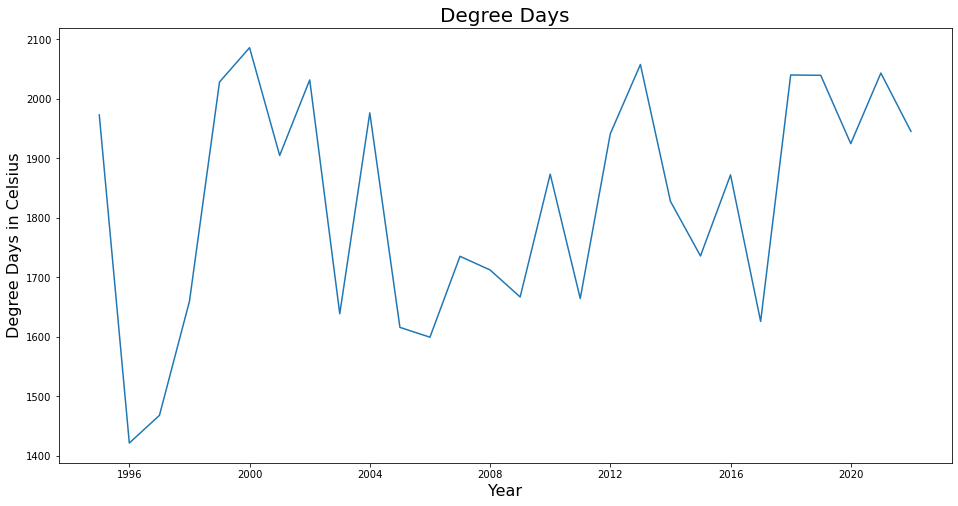

In [259]:
# Plot of degree days/year
plt.figure(figsize=(16, 8))
plt.plot(df2['dd'].resample('y').sum())
plt.title('Degree Days', fontsize = 20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Degree Days in Celsius',fontsize =16)

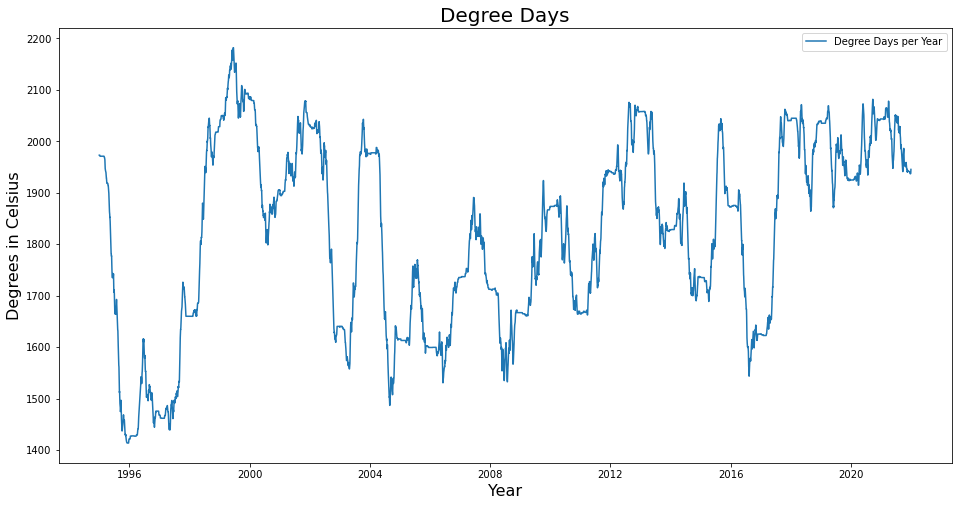

In [260]:
# Degree days using rolling mean for 365 days
plt.figure(figsize=(16, 8))
plt.plot(df2['dd'].rolling(365).sum(), label='Degree Days per Year')
#plt.plot(df2['dd'].rolling(30).mean() , label='Daily Min Temperature')
plt.title('Degree Days', fontsize = 20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Degrees in Celsius',fontsize =16)
plt.legend()
plt.savefig('images/degree_days.png', bbox_inches='tight');

### Temperatures

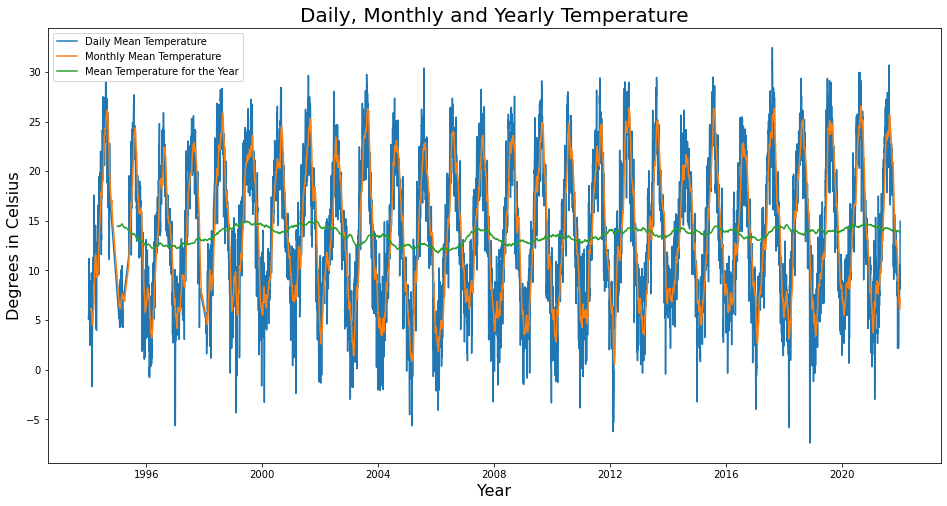

In [261]:
# dayly temperatures, monthly mean and yearly mean
plt.figure(figsize=(16, 8))
plt.plot(df2['t_mean'], label='Daily Mean Temperature')
plt.plot(df2['t_mean'].rolling(30).mean(), label='Monthly Mean Temperature')
plt.plot(df2['t_mean'].rolling(365).mean(), label='Mean Temperature for the Year')
plt.title('Daily, Monthly and Yearly Temperature', fontsize = 20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Degrees in Celsius',fontsize =16)
plt.legend();

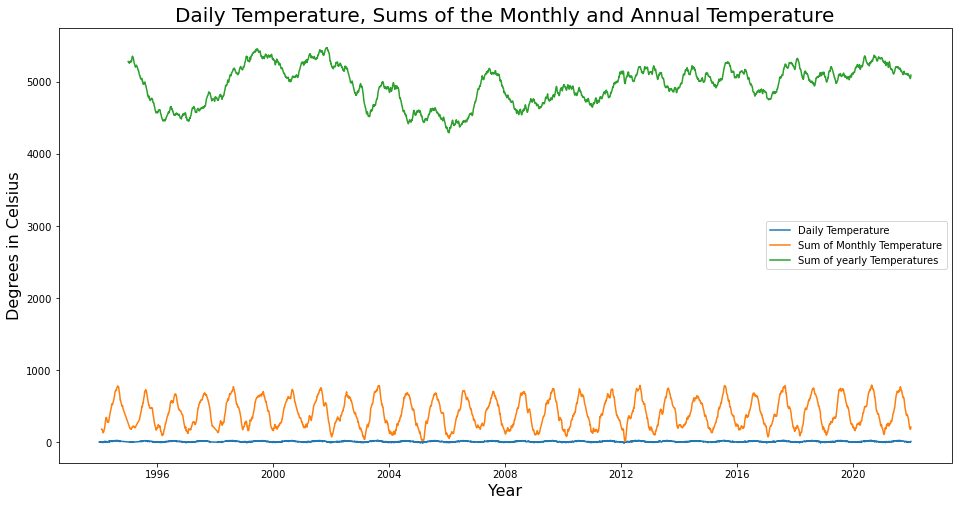

In [262]:
# dayly temperatures, monthly and yearly sum
plt.figure(figsize=(16, 8))
plt.plot(df2['t_mean'], label='Daily Temperature')
plt.plot(df2['t_mean'].rolling(30).sum(), label='Sum of Monthly Temperature')
plt.plot(df2['t_mean'].rolling(365).sum(), label='Sum of yearly Temperatures ')
plt.title('Daily Temperature, Sums of the Monthly and Annual Temperature', fontsize = 20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Degrees in Celsius',fontsize =16)
plt.legend();

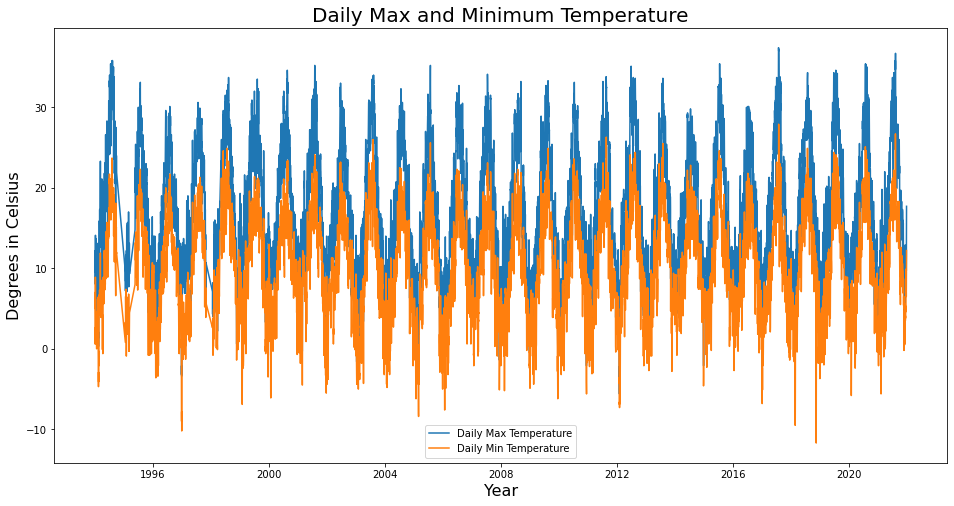

In [263]:
# Max and MinsTemperatures means
plt.figure(figsize=(16, 8))
plt.plot(df2['max'], label='Daily Max Temperature')
plt.plot(df2['min'], label='Daily Min Temperature')
plt.title('Daily Max and Minimum Temperature', fontsize = 20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Degrees in Celsius',fontsize =16)
plt.legend();

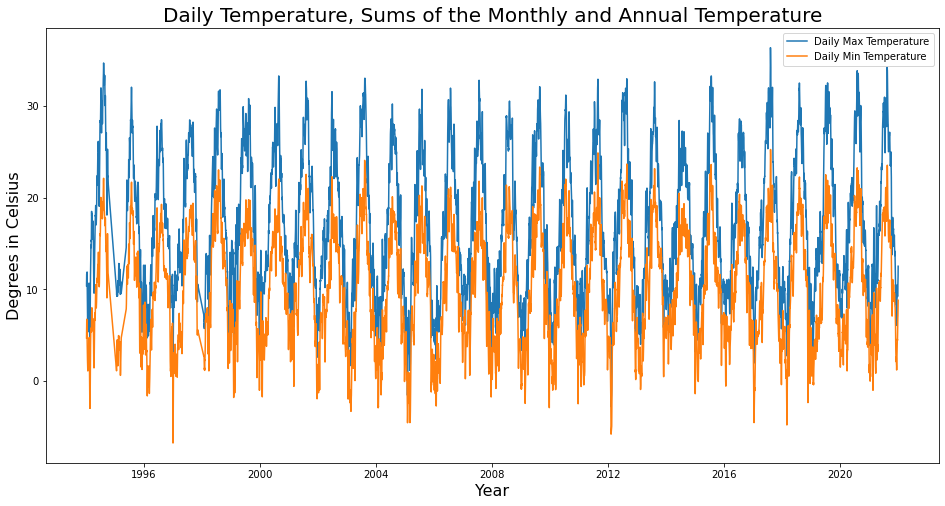

In [264]:
# Max and MinsTemperatures means
plt.figure(figsize=(16, 8))
plt.plot(df2['max'].rolling(7).mean(), label='Daily Max Temperature')
plt.plot(df2['min'].rolling(7).mean() , label='Daily Min Temperature')
plt.title('Daily Temperature, Sums of the Monthly and Annual Temperature', fontsize = 20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Degrees in Celsius',fontsize =16)
plt.legend();

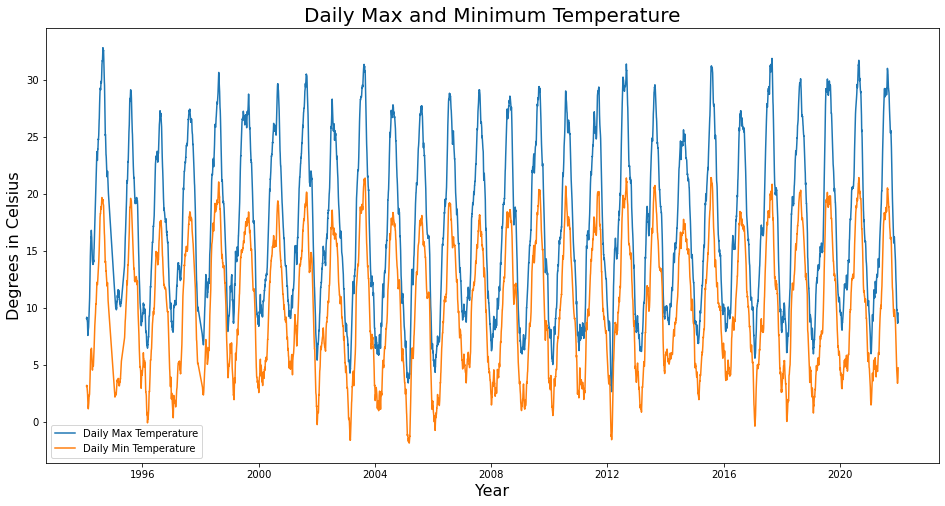

In [265]:
# Max and Mins Temperatures using 30 days rolling mean for clarity
plt.figure(figsize=(16, 8))
plt.plot(df2['max'].rolling(30).mean(), label='Daily Max Temperature')
plt.plot(df2['min'].rolling(30).mean() , label='Daily Min Temperature')
plt.title('Daily Max and Minimum Temperature', fontsize = 20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Degrees in Celsius',fontsize =16)
plt.savefig('images/daily_max_min_temp.png', bbox_inches='tight')
plt.legend();

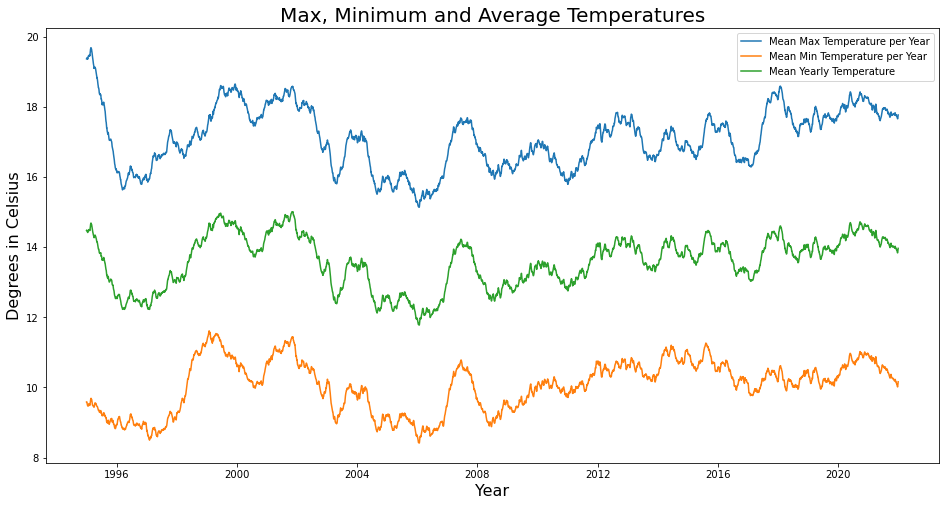

In [266]:
# Max and Mins Temperatures with a rolling mean of one year
plt.figure(figsize=(16, 8))
plt.plot(df2['max'].rolling(365).mean(), label='Mean Max Temperature per Year')
plt.plot(df2['min'].rolling(365).mean() , label='Mean Min Temperature per Year')
plt.plot(df2['t_mean'].rolling(365).mean(), label='Mean Yearly Temperature')
plt.title('Max, Minimum and Average Temperatures', fontsize = 20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Degrees in Celsius',fontsize =16)
plt.legend()
plt.savefig('images/min_max_mean_temp.png', bbox_inches='tight');

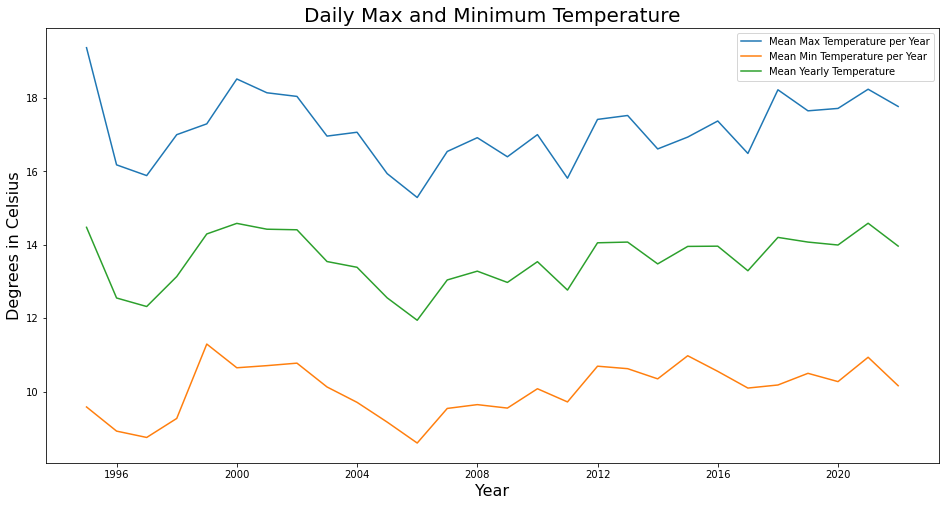

In [267]:
# Max and Mins Temperatures with a resample mean of one year
plt.figure(figsize=(16, 8))
plt.plot(df2['max'].resample('y').mean(), label='Mean Max Temperature per Year')
plt.plot(df2['min'].resample('y').mean() , label='Mean Min Temperature per Year')
plt.plot(df2['t_mean'].resample('y').mean(), label='Mean Yearly Temperature')
plt.title('Daily Max and Minimum Temperature', fontsize = 20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Degrees in Celsius',fontsize =16)
plt.legend()

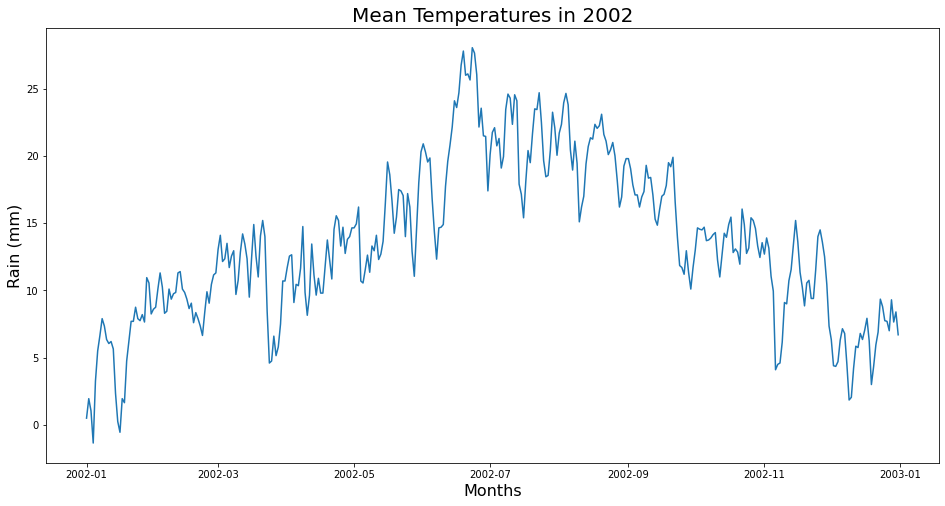

In [268]:
df_x = df2.loc['2002']
plt.figure(figsize=(16, 8))
plt.plot(df_x['t_mean'])
plt.title('Mean Temperatures in 2002', fontsize = 20)
plt.xlabel('Months',fontsize=16)
plt.ylabel('Rain (mm)',fontsize =16)
plt.savefig('images/mean_t_2002.png', bbox_inches='tight')

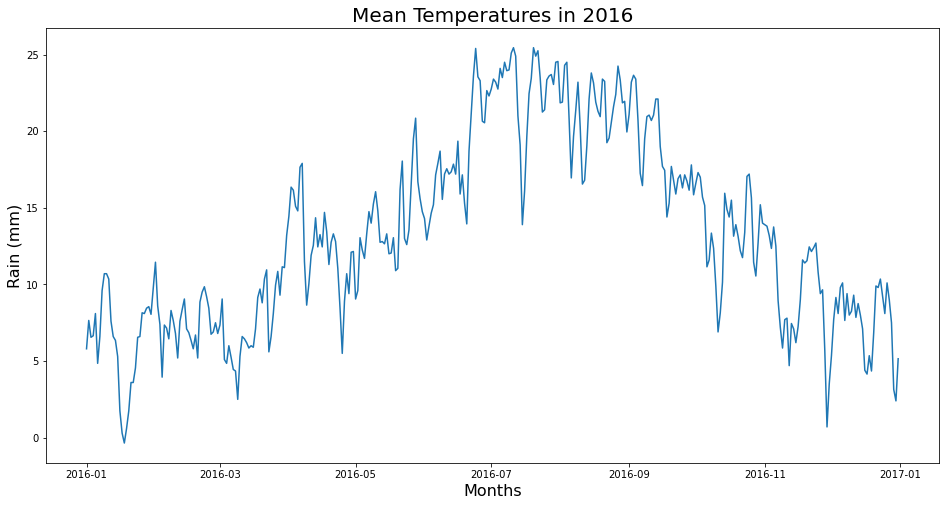

In [269]:
df_x = df2.loc['2016']
plt.figure(figsize=(16, 8))
plt.plot(df_x['t_mean'])
plt.title('Mean Temperatures in 2016', fontsize = 20)
plt.xlabel('Months',fontsize=16)
plt.ylabel('Rain (mm)',fontsize =16)
plt.savefig('images/mean_t_2016.png', bbox_inches='tight')

### Precipitation

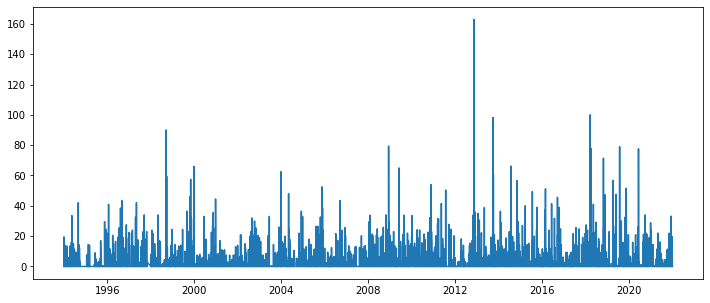

In [270]:
# Precipitation
plt.figure(figsize=(12, 5))
plt.plot(df2['prec'], label='Daily Precipitation')

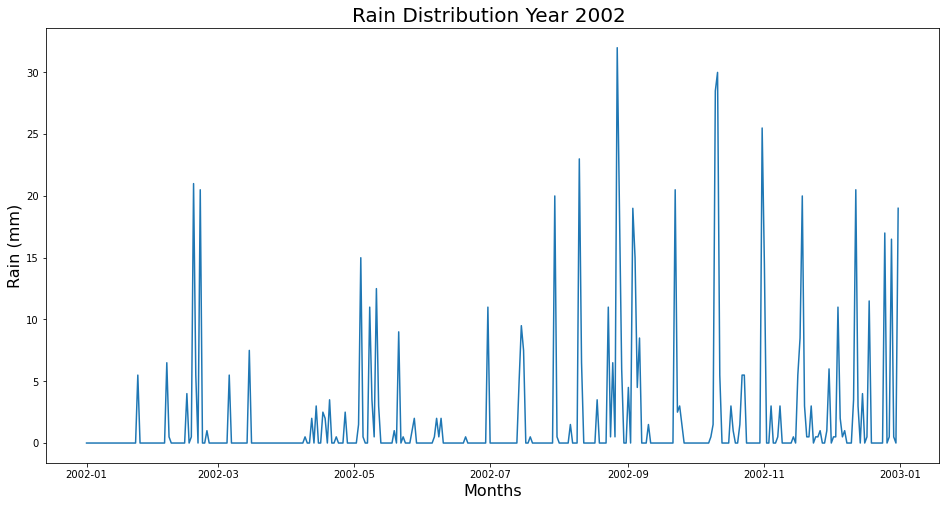

In [271]:
df_x = df2.loc['2002']
plt.figure(figsize=(16, 8))
plt.plot(df_x['prec'])
plt.title('Rain Distribution Year 2002 ', fontsize = 20)
plt.xlabel('Months',fontsize=16)
plt.ylabel('Rain (mm)',fontsize =16)
plt.savefig('images/rain_dist_2002.png', bbox_inches='tight');

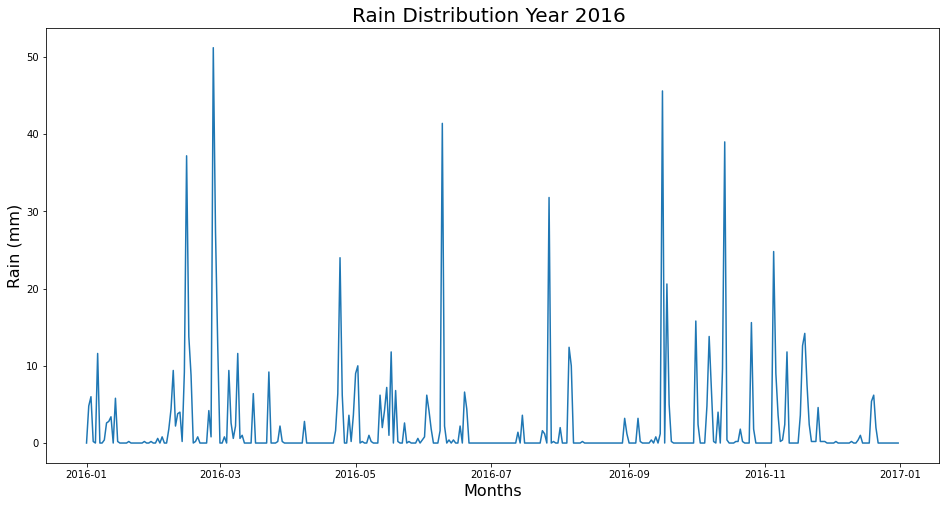

In [272]:
df_x = df2.loc['2016']
plt.figure(figsize=(16, 8))
plt.plot(df_x['prec'])
plt.title('Rain Distribution Year 2016 ', fontsize = 20)
plt.xlabel('Months',fontsize=16)
plt.ylabel('Rain (mm)',fontsize =16)
plt.savefig('images/rain_dist_2016.png', bbox_inches='tight')

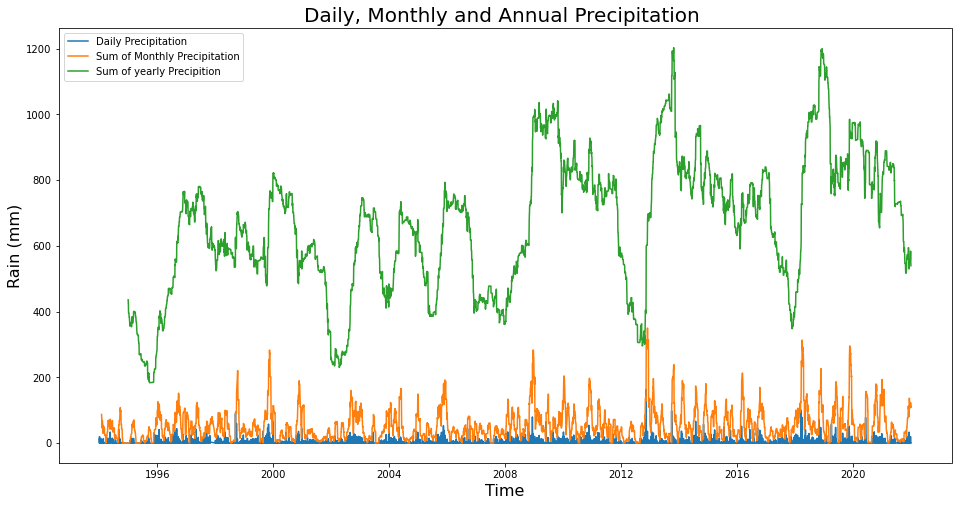

In [273]:
# 
plt.figure(figsize=(16, 8))
plt.plot(df2['prec'], label='Daily Precipitation')
plt.plot(df2['prec'].rolling(30).sum(), label='Sum of Monthly Precipitation')
plt.plot(df2['prec'].rolling(365).sum(), label='Sum of yearly Precipition')
plt.title('Daily, Monthly and Annual Precipitation ', fontsize = 20)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Rain (mm)',fontsize =16)
plt.legend()
plt.savefig('images/d_m_y_total_temp.png', bbox_inches='tight');

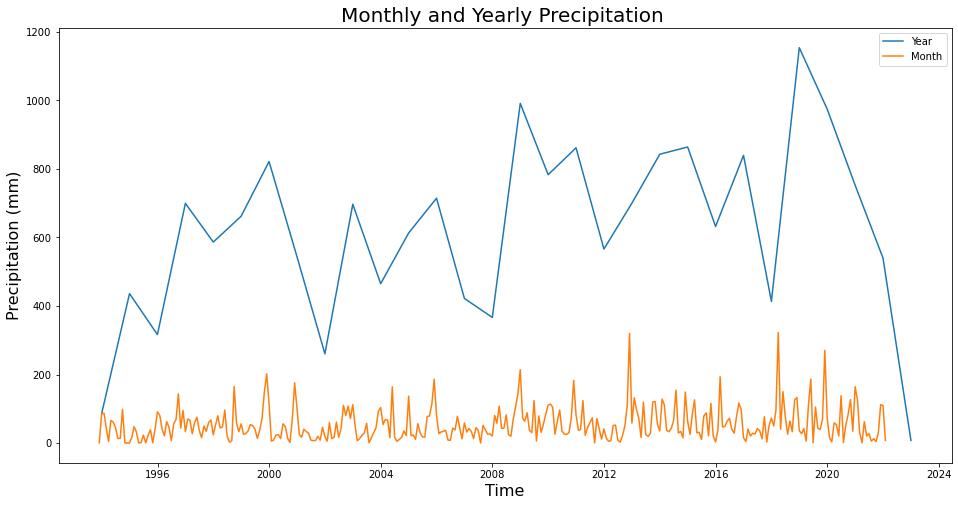

In [274]:
plt.figure(figsize=(16, 8))
plt.plot(year_sum['prec'], label='Year')
plt.plot(month_sum['prec_sum'], label='Month')
#plt.plot(df2['prec'].rolling(30).sum(), label='Sum of Monthly Precipitation')
#plt.plot(df2['prec'].rolling(365).sum(), label='Sum of yearly Precipition')
plt.title('Monthly and Yearly Precipitation ', fontsize = 20)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Precipitation (mm)',fontsize =16)
plt.legend();

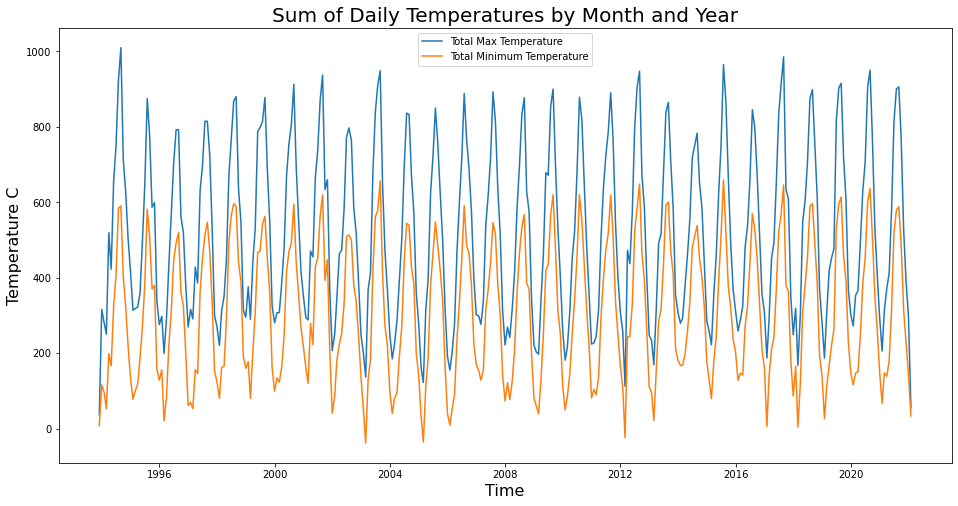

In [275]:
plt.figure(figsize=(16, 8))
plt.plot(month_sum['max_sum'], label='Total Max Temperature')
plt.plot(month_sum['min_sum'], label='Total Minimum Temperature')
#plt.plot(df2['prec'].rolling(30).sum(), label='Sum of Monthly Precipitation')
#plt.plot(df2['prec'].rolling(365).sum(), label='Sum of yearly Precipition')
plt.title('Sum of Daily Temperatures by Month and Year', fontsize = 20)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Temperature C',fontsize =16)
plt.legend();

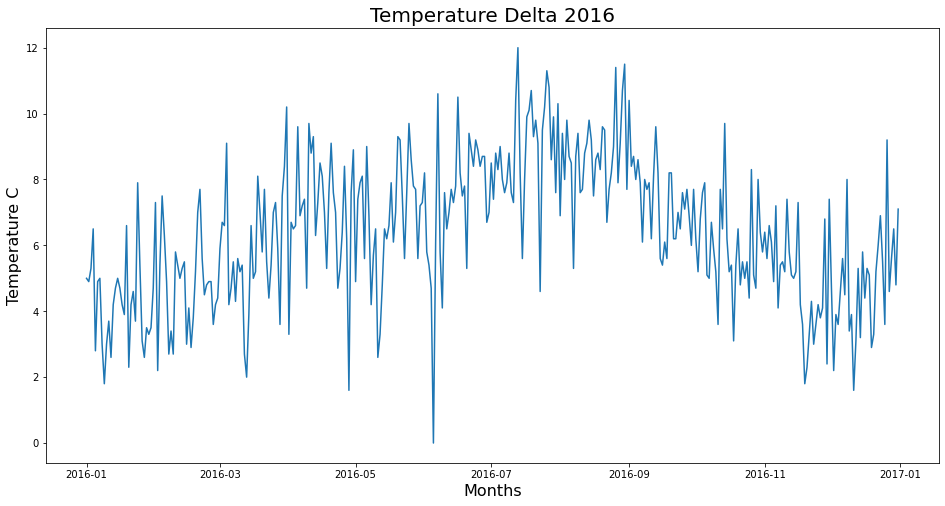

In [276]:
df_x = df2.loc['2016']
plt.figure(figsize=(16, 8))
plt.plot(df_x['delta_t'])
plt.title('Temperature Delta 2016', fontsize = 20)
plt.xlabel('Months',fontsize=16)
plt.ylabel('Temperature C',fontsize =16)
plt.savefig('images/delta_t_2016.png', bbox_inches='tight')

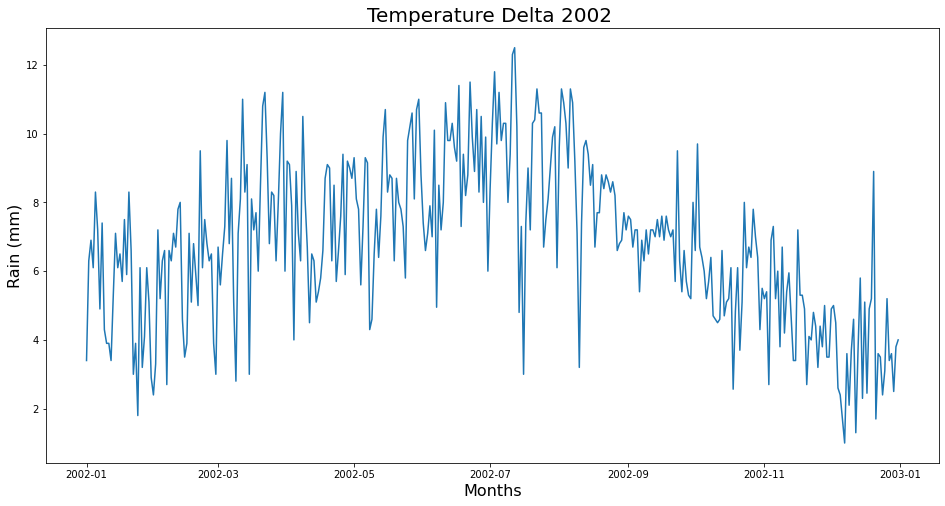

In [277]:
df_x = df2.loc['2002']
plt.figure(figsize=(16, 8))
plt.plot(df_x['delta_t'])
plt.title('Temperature Delta 2002 ', fontsize = 20)
plt.xlabel('Months',fontsize=16)
plt.ylabel('Rain (mm)',fontsize =16)
plt.savefig('images/delta_2002.png', bbox_inches='tight')

### Vintage Score

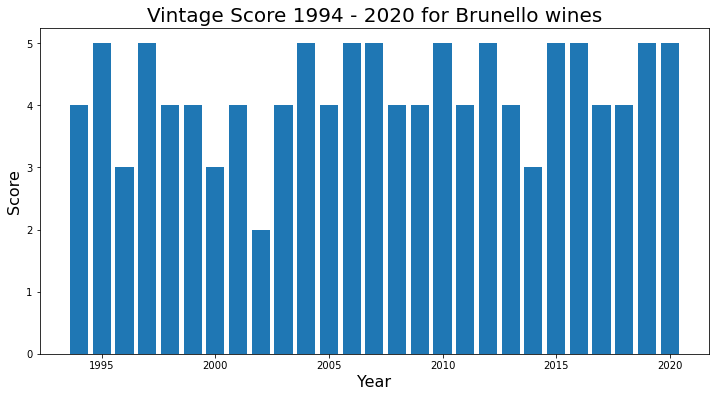

In [278]:
score[score['year']>1994]
plt.figure(figsize=(12, 6))
plt.title('Vintage Score 1994 - 2020 for Brunello wines', fontsize = 20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Score',fontsize =16)
plt.bar(x=score['year'], height=score['score'])
plt.savefig('images/vintage_chart.png', bbox_inches='tight');

### Heat Maps

<AxesSubplot:title={'center':'Complete Data'}>

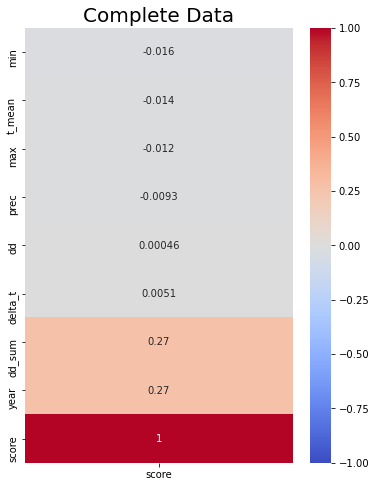

In [279]:
# All data
plt.figure(figsize=(6, 8))
plt.title('Complete Data', fontsize = 20)
sns.heatmap(df2.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')



In [280]:
#month_sum['1-1-1994' : '31-12-2020']
#month_sum[month_sum['year'].between(1994, 2020)]
#month_sum.head()


<AxesSubplot:title={'center':'Totals per Year'}>

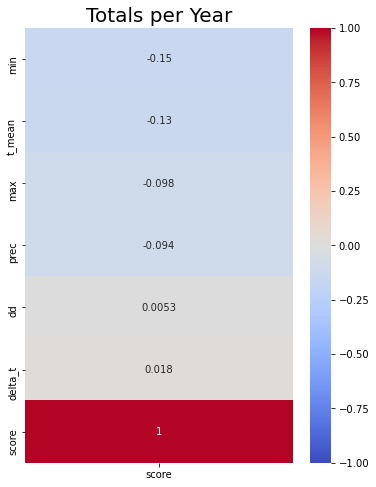

In [281]:
# Sums for each year
plt.figure(figsize=(6, 8))
plt.title('Totals per Year', fontsize = 20)
sns.heatmap(df_year_sum.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

<AxesSubplot:title={'center':'Means per Year'}>

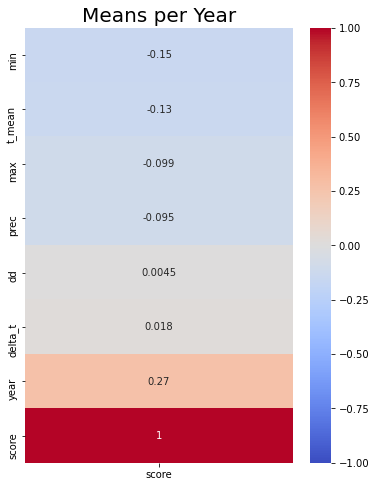

In [282]:
# Means for each year
plt.figure(figsize=(6, 8))
plt.title('Means per Year', fontsize = 20)
sns.heatmap(df_year_mean.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

In [283]:
# Narrowing down to the period 1994-2020 where there are not NaNs
#month_sum[month_sum['year'].between(1994, 2020)]
# SEE BELOW

In [284]:
# Limiting the data to the period 1994-2020 where there are no NaNs
df_month = df_month['1-1-1994' : '31-12-2020']
df_month.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-01-31,87.0,280.3,95.40,187.850,2.050,184.90,1994,1,2.806452,9.041935,3.077419,4.0,6.059677,0.066129,5.964516
1994-02-28,46.0,250.2,52.90,151.550,0.500,197.30,1994,2,1.642857,8.935714,1.889286,4.0,5.412500,0.017857,7.046429
1994-03-31,4.5,519.1,198.90,359.000,52.750,320.20,1994,3,0.145161,16.745161,6.416129,4.0,11.580645,1.701613,10.329032
1994-04-30,66.0,422.6,166.85,294.725,40.325,255.75,1994,4,2.200000,14.086667,5.561667,4.0,9.824167,1.344167,8.525000
1994-05-31,61.0,655.8,325.10,490.450,180.900,330.70,1994,5,1.967742,21.154839,10.487097,4.0,15.820968,5.835484,10.667742


<AxesSubplot:title={'center':'Means and Sums per Month'}>

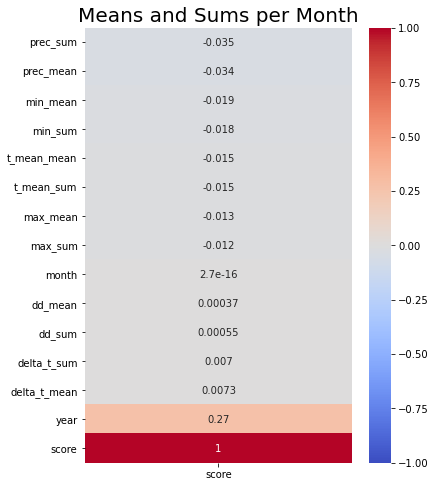

In [285]:
# Correlation for monthly data for all 12 months. It incluedes both, means and sums
plt.figure(figsize=(6, 8))
plt.title('Means and Sums per Month', fontsize = 20)
sns.heatmap(df_month.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

In [286]:
# Selecting the period April-October that coincinde with the period of active growth of the plant
df_month_grow = df_month[df_month['month'].between(4, 10)]

In [287]:
df_month_grow.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-04-30,66.0,422.6,166.85,294.725,40.325,255.75,1994,4,2.200000,14.086667,5.561667,4.0,9.824167,1.344167,8.525000
1994-05-31,61.0,655.8,325.10,490.450,180.900,330.70,1994,5,1.967742,21.154839,10.487097,4.0,15.820968,5.835484,10.667742
1994-06-30,46.0,748.5,404.90,576.700,276.700,343.60,1994,6,1.533333,24.950000,13.496667,4.0,19.223333,9.223333,11.453333
1994-07-31,13.5,923.0,584.50,753.750,443.750,338.50,1994,7,0.435484,29.774194,18.854839,4.0,24.314516,14.314516,10.919355
1994-08-31,13.5,1009.5,589.70,799.600,489.600,419.80,1994,8,0.435484,32.564516,19.022581,4.0,25.793548,15.793548,13.541935


<AxesSubplot:title={'center':'Monthly for April - October'}>

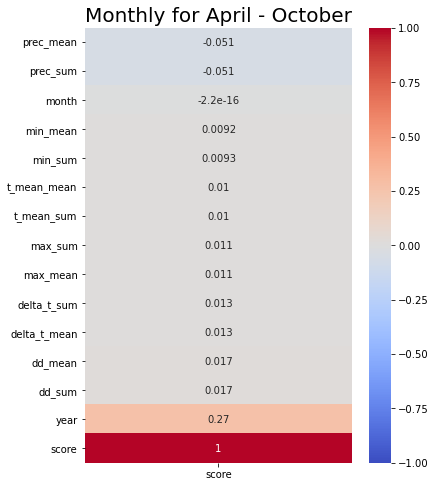

In [288]:
plt.figure(figsize=(6, 8))
plt.title('Monthly for April - October', fontsize = 20)
sns.heatmap(df_month_grow.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

In [289]:
# Selecting the period July-October that coincinde with the period of active growth of the plant
df_month_grow = df_month[df_month['month'].between(7, 10)]
df_month_grow.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-07-31,13.5,923.000000,584.5,753.750000,443.750000,338.500000,1994,7,0.435484,29.774194,18.854839,4.0,24.314516,14.314516,10.919355
1994-08-31,13.5,1009.500000,589.7,799.600000,489.600000,419.800000,1994,8,0.435484,32.564516,19.022581,4.0,25.793548,15.793548,13.541935
1994-09-30,98.5,713.400000,403.3,558.350000,258.350000,310.100000,1994,9,3.283333,23.780000,13.443333,4.0,18.611667,8.611667,10.336667
1994-10-31,0.0,626.642857,322.4,474.521429,164.521429,304.242857,1994,10,0.000000,20.214286,10.400000,4.0,15.307143,5.307143,9.814286
1995-07-31,0.5,874.800000,581.8,728.300000,418.300000,293.000000,1995,7,0.016129,28.219355,18.767742,5.0,23.493548,13.493548,9.451613


<AxesSubplot:title={'center':'Monthly for July - October'}>

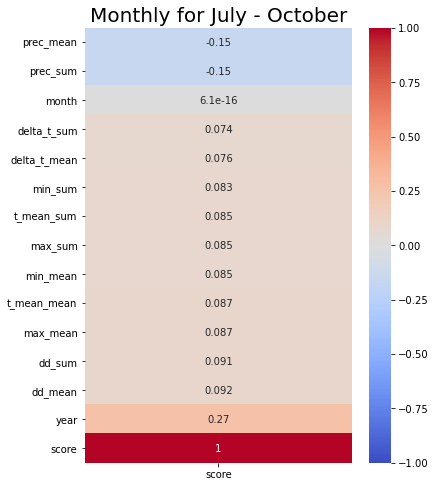

In [290]:
# Checking correlations for the period July - October
plt.figure(figsize=(6, 8))
plt.title('Monthly for July - October', fontsize = 20)
sns.heatmap(df_month_grow.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

In [291]:
# Selecting the period August-October that coincinde with the period of active growth of the plant
df_month_grow = df_month[df_month['month'].between(8, 10)]
df_month_grow.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-08-31,13.5,1009.500000,589.7,799.600000,489.600000,419.800000,1994,8,0.435484,32.564516,19.022581,4.0,25.793548,15.793548,13.541935
1994-09-30,98.5,713.400000,403.3,558.350000,258.350000,310.100000,1994,9,3.283333,23.780000,13.443333,4.0,18.611667,8.611667,10.336667
1994-10-31,0.0,626.642857,322.4,474.521429,164.521429,304.242857,1994,10,0.000000,20.214286,10.400000,4.0,15.307143,5.307143,9.814286
1995-08-31,22.5,773.100000,506.1,639.600000,329.600000,267.000000,1995,8,0.725806,24.938710,16.325806,5.0,20.632258,10.632258,8.612903
1995-09-30,39.0,586.700000,370.3,478.500000,178.500000,216.400000,1995,9,1.300000,19.556667,12.343333,5.0,15.950000,5.950000,7.213333


<AxesSubplot:title={'center':'Monthly for August-October'}>

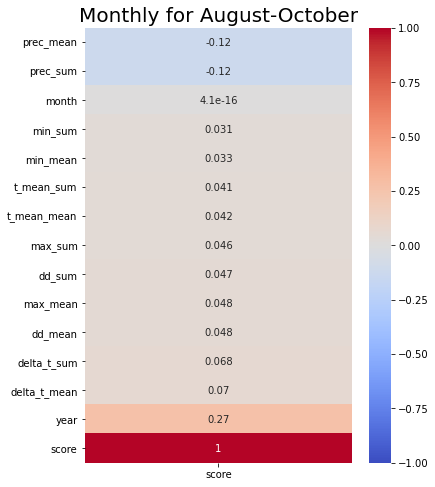

In [292]:
# Checking correlations for the period August - October
plt.figure(figsize=(6, 8))
plt.title('Monthly for August-October', fontsize = 20)
sns.heatmap(df_month_grow.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

In [293]:
# Selecting the period July- September that coincinde with the period of active growth of the plant
df_month_grow = df_month[df_month['month'].between(7, 9)]
df_month_grow.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-07-31,13.5,923.0,584.5,753.75,443.75,338.5,1994,7,0.435484,29.774194,18.854839,4.0,24.314516,14.314516,10.919355
1994-08-31,13.5,1009.5,589.7,799.60,489.60,419.8,1994,8,0.435484,32.564516,19.022581,4.0,25.793548,15.793548,13.541935
1994-09-30,98.5,713.4,403.3,558.35,258.35,310.1,1994,9,3.283333,23.780000,13.443333,4.0,18.611667,8.611667,10.336667
1995-07-31,0.5,874.8,581.8,728.30,418.30,293.0,1995,7,0.016129,28.219355,18.767742,5.0,23.493548,13.493548,9.451613
1995-08-31,22.5,773.1,506.1,639.60,329.60,267.0,1995,8,0.725806,24.938710,16.325806,5.0,20.632258,10.632258,8.612903


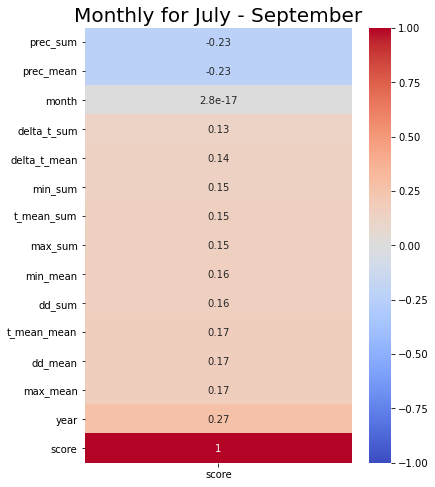

In [294]:
# Checking correlations for the period July - September
plt.figure(figsize=(6, 8))
plt.title('Monthly for July - September', fontsize = 20)
sns.heatmap(df_month_grow.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.savefig('images/heat_map_july_september.png', bbox_inches='tight')

In [295]:
# Selecting the period June- September that coincinde with the period of active growth of the plant
df_month_grow = df_month[df_month['month'].between(6, 9)]
df_month_grow.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-06-30,46.0,748.5,404.9,576.70,276.70,343.6,1994,6,1.533333,24.950000,13.496667,4.0,19.223333,9.223333,11.453333
1994-07-31,13.5,923.0,584.5,753.75,443.75,338.5,1994,7,0.435484,29.774194,18.854839,4.0,24.314516,14.314516,10.919355
1994-08-31,13.5,1009.5,589.7,799.60,489.60,419.8,1994,8,0.435484,32.564516,19.022581,4.0,25.793548,15.793548,13.541935
1994-09-30,98.5,713.4,403.3,558.35,258.35,310.1,1994,9,3.283333,23.780000,13.443333,4.0,18.611667,8.611667,10.336667
1995-06-30,23.0,647.0,381.5,514.25,214.25,265.5,1995,6,0.766667,21.566667,12.716667,5.0,17.141667,7.141667,8.850000


<AxesSubplot:title={'center':'Monthly for June - September'}>

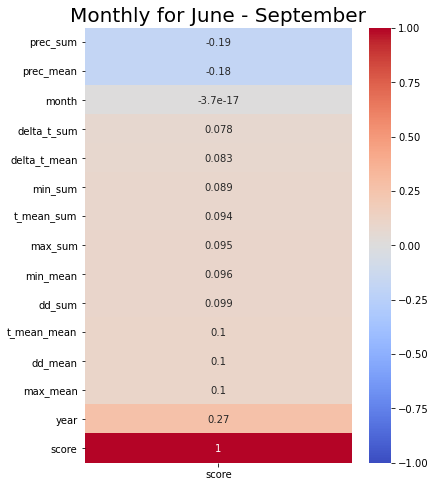

In [296]:
# Checking correlations for the period June - September
plt.figure(figsize=(6, 8))
plt.title('Monthly for June - September', fontsize = 20)
sns.heatmap(df_month_grow.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

In [297]:
# Limiting the timeframe 1994 -2020
df_year_sum = df_year_sum['1994' : '2020']
df_year_sum.head()

,score,prec,max,min,t_mean,dd,delta_t
date,,,,,,,
1994-12-31,4.0,436.0,7068.944643,3497.750000,5283.347321,1972.993304,3571.194643
1995-12-31,5.0,316.5,5904.255357,3257.650000,4580.952679,1421.300000,2646.605357
1996-12-31,3.0,699.5,5813.500000,3203.350000,4508.425000,1467.825000,2610.150000
1997-12-31,5.0,586.5,6204.280723,3383.572289,4793.926506,1659.850000,2820.708434
1998-12-31,4.0,662.0,6311.869277,4122.927711,5217.398494,2028.375000,2188.941566


<AxesSubplot:title={'center':'Sums for Each Year'}>

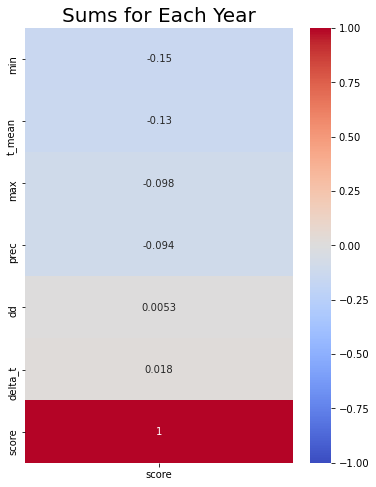

In [298]:
# Checking correlations for the sums for each year
plt.figure(figsize=(6, 8))
plt.title('Sums for Each Year', fontsize = 20)
sns.heatmap(df_year_sum.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

In [299]:
# Limiting the timeframe 1994 -2020 for the means
df_year_mean = df_year_mean['1994' : '2020']
df_year_mean.head()

,prec,max,min,year,score,t_mean,dd,delta_t
date,,,,,,,,
1994-12-31,1.194521,19.366972,9.582877,1994,4.0,14.474924,5.405461,9.784095
1995-12-31,0.867123,16.176042,8.925068,1995,5.0,12.550555,3.893973,7.250974
1996-12-31,1.911202,15.883880,8.752322,1996,3.0,12.318101,4.010451,7.131557
1997-12-31,1.606849,16.998029,9.270061,1997,5.0,13.134045,4.547534,7.727968
1998-12-31,1.813699,17.292793,11.295692,1998,4.0,14.294242,5.557192,5.997100


<AxesSubplot:title={'center':'Means for Each Year'}>

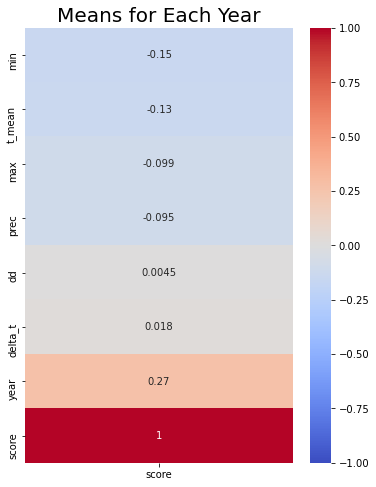

In [300]:
# Checking correlations for the sums for each year
plt.figure(figsize=(6, 8))
plt.title('Means for Each Year', fontsize = 20)
sns.heatmap(df_year_mean.corr()[['score']].sort_values('score'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

# 8 Models
### 8.1 On entire dataset
First, I will run several model on the original dataset, containing daily data.  This will give me an idea of the quality of the model and how well (or bad) they can predict wine score.
Before I run the model I will prepare the dataset by limiting the timeframe from 1994 through 2020.  Because data collection started at the end of 1993 I need to eliminate all data previous to 1994.  Because the last reported score is from 2020 I need to drop all data after 31-12-2020 

In [301]:
# Checking the dataset for NaNs
df2.isnull().sum()

prec         0
notes        0
max          0
min          0
year         0
score      365
t_mean       0
dd           0
dd_sum       0
delta_t      0
dtype: int64

In [302]:
# Need to drop 2021 because there is not score for this year
# I will have to do it before the EDA so there is consistancy
df2 = df2['1-1-1994' : '31-12-2020']
df2.tail()

,prec,notes,max,min,year,score,t_mean,dd,dd_sum,delta_t
date,,,,,,,,,,
2020-12-27,0.4,P,3.6,-0.2,2020,5.0,1.70,0.0,49164.518304,3.8
2020-12-28,28.8,P,8.1,0.2,2020,5.0,4.15,0.0,49164.518304,7.9
2020-12-29,4.0,P,7.8,3.1,2020,5.0,5.45,0.0,49164.518304,4.7
2020-12-30,11.6,P,6.2,1.2,2020,5.0,3.70,0.0,49164.518304,5.0
2020-12-31,0.2,P,6.9,-0.2,2020,5.0,3.35,0.0,49164.518304,7.1


In [303]:
# X and y
X = df2.drop(columns=['notes', 'score', 'dd_sum'])
y = df2['score']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [304]:
# Define the models 
lr = LinearRegression()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor(random_state=42)
bag = BaggingRegressor()
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Instantiate a pipeline foe each model
pipe_lr = Pipeline([
    ('lr', LinearRegression())
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

pipe_dtr = Pipeline([
    #('ss', StandardScaler()),
    ('dtr', DecisionTreeRegressor())
])
    
pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingRegressor())
])    
    
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42)) 
])
    
pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor(random_state=42))
    
])


# Fit the models
pipe_lr.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_dtr.fit(X_train, y_train)
pipe_bag.fit(X_train,y_train)
pipe_rf.fit(X_train,y_train)
pipe_gboost.fit(X_train,y_train)

# Print out Scores for the models
print(f'Linear Regression Train Score is: {pipe_lr.score(X_train,y_train)}')
print(f'Linear Regression Test Score is: {pipe_lr.score(X_test,y_test)}')

print(f'KNN Train Score is: {pipe_knn.score(X_train,y_train)}')
print(f'KNN Test Score is: {pipe_knn.score(X_test,y_test)}')

print(f'Decision Tree Regressor  Train Score is: {pipe_dtr.score(X_train,y_train)}')
print(f'Decision Tree Regressor Test Score is: {pipe_dtr.score(X_test,y_test)}')
    
print(f'Bagging Regressor Train Score is: {pipe_bag.score(X_train,y_train)}')
print(f'Bagging Regressor Test Score is: {pipe_bag.score(X_test,y_test)}') 
    
print(f'Random Forest Regressors Train Score is: {pipe_rf.score(X_train,y_train)}')
print(f'Random Forest Regressors Test Score is: {pipe_rf.score(X_test,y_test)}')
    
print(f'Gradient Boost Train Score is: {pipe_gboost.score(X_train,y_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X_test,y_test)}')   

Linear Regression Train Score is: 0.039908047263712776
Linear Regression Test Score is: 0.05741595090059093
KNN Train Score is: 0.6563647196853777
KNN Test Score is: -1.95837640505821
Decision Tree Regressor  Train Score is: 1.0
Decision Tree Regressor Test Score is: -4.652762444801285
Bagging Regressor Train Score is: 1.0
Bagging Regressor Test Score is: -4.652762444801285
Random Forest Regressors Train Score is: 1.0
Random Forest Regressors Test Score is: -4.652762444801285
Gradient Boost Train Score is: 0.9955748802940587
Gradient Boost Test Score is: -4.371550106730543


In [305]:
def print_scores(y_test,preds,model_type):
    print(f'{model_type} R2 Score: {metrics.r2_score(y_test,preds)}')

    print(f'{model_type} MAE Score: {metrics.mean_absolute_error(y_test, preds)}')

    print(f'{model_type} RMSE Score: {metrics.mean_squared_error(y_test, preds, squared=False)}')

    print(f'{model_type} MSE Score: {metrics.mean_squared_error(y_test, preds)}')

#preds_ada = pipe_ada.predict(X_test)
#print_scores(y_test,preds_ada, 'Ada Boost')
preds_lr=pipe_lr.predict(X_test)
print_scores(y_test,preds_lr, 'Linear Regression')
preds_rf = pipe_rf.predict(X_test)
print_scores(y_test,preds_rf, 'Random Forest')
preds_bagging = pipe_bag.predict(X_test)
print_scores(y_test,preds_bagging, 'Bagging')

Linear Regression R2 Score: 0.05741595090059093
Linear Regression MAE Score: 0.6040332028588286
Linear Regression RMSE Score: 0.6669297246903552
Linear Regression MSE Score: 0.444795257675553
Random Forest R2 Score: -4.652762444801285
Random Forest MAE Score: 1.4817518248175183
Random Forest RMSE Score: 1.6332414691878163
Random Forest MSE Score: 2.667477696674777
Bagging R2 Score: -4.652762444801285
Bagging MAE Score: 1.4817518248175183
Bagging RMSE Score: 1.6332414691878163
Bagging MSE Score: 2.667477696674777


### 8.2 On means summary per month
For this dataset I calculated the mean of the variables for each month.  The timeframe is 1994-2020.

In [306]:
# Removing 2021 data that have NaN score
month_mean = month_mean['1-1-1994' : '31-12-2020']
month_mean.tail()

,prec_mean,max_mean,min_mean,year,score,t_mean_mean,dd_mean,delta_t_mean,month
date,,,,,,,,,
2020-08-31,1.683871,30.645161,20.525806,2020,5.0,25.585484,15.585484,10.119355,8
2020-09-30,2.780000,25.603333,16.923333,2020,5.0,21.263333,11.295000,8.680000,9
2020-10-31,4.083871,17.145161,11.296774,2020,5.0,14.220968,4.220968,5.848387,10
2020-11-30,1.146667,13.596667,8.723333,2020,5.0,11.160000,1.865000,4.873333,11
2020-12-31,5.303226,9.470968,4.764516,2020,5.0,7.117742,0.158065,4.706452,12


In [307]:
# X and y
X = month_mean.drop(columns=['score', 'month'])
y = month_mean['score']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [308]:
# Define the models 
lr = LinearRegression()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor(random_state=42)
bag = BaggingRegressor()
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Instantiate a pipeline foe each model
pipe_lr = Pipeline([
    ('lr', LinearRegression())
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

pipe_dtr = Pipeline([
    #('ss', StandardScaler()),
    ('dtr', DecisionTreeRegressor())
])
    
pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingRegressor())
])    
    
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42)) 
])
    
pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor(random_state=42))
    
])


# Fit the models
pipe_lr.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_dtr.fit(X_train, y_train)
pipe_bag.fit(X_train,y_train)
pipe_rf.fit(X_train,y_train)
pipe_gboost.fit(X_train,y_train)

# Print out Scores for the models
print(f'Linear Regression Train Score is: {pipe_lr.score(X_train,y_train)}')
print(f'Linear Regression Test Score is: {pipe_lr.score(X_test,y_test)}')

print(f'KNN Train Score is: {pipe_knn.score(X_train,y_train)}')
print(f'KNN Test Score is: {pipe_knn.score(X_test,y_test)}')

print(f'Decision Tree Regressor  Train Score is: {pipe_dtr.score(X_train,y_train)}')
print(f'Decision Tree Regressor Test Score is: {pipe_dtr.score(X_test,y_test)}')
    
print(f'Bagging Regressor Train Score is: {pipe_bag.score(X_train,y_train)}')
print(f'Bagging Regressor Test Score is: {pipe_bag.score(X_test,y_test)}') 
    
print(f'Random Forest Regressors Train Score is: {pipe_rf.score(X_train,y_train)}')
print(f'Random Forest Regressors Test Score is: {pipe_rf.score(X_test,y_test)}')
    
print(f'Gradient Boost Train Score is: {pipe_gboost.score(X_train,y_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X_test,y_test)}')   

Linear Regression Train Score is: 0.06142501365647457
Linear Regression Test Score is: 0.02929724151761992
KNN Train Score is: 0.46569511025886867
KNN Test Score is: -0.2306976744186049
Decision Tree Regressor  Train Score is: 1.0
Decision Tree Regressor Test Score is: -4.6511627906976765
Bagging Regressor Train Score is: 0.977607861936721
Bagging Regressor Test Score is: -3.4118313953488384
Random Forest Regressors Train Score is: 0.9901791706615533
Random Forest Regressors Test Score is: -3.812619186046514
Gradient Boost Train Score is: 0.9911943277583936
Gradient Boost Test Score is: -4.200049870620094


In [309]:
def print_scores(y_test,preds,model_type):
    print(f'{model_type} R2 Score: {metrics.r2_score(y_test,preds)}')

    print(f'{model_type} MAE Score: {metrics.mean_absolute_error(y_test, preds)}')

    print(f'{model_type} RMSE Score: {metrics.mean_squared_error(y_test, preds, squared=False)}')

    print(f'{model_type} MSE Score: {metrics.mean_squared_error(y_test, preds)}')

#preds_ada = pipe_ada.predict(X_test)
#print_scores(y_test,preds_ada, 'Ada Boost')
preds_lr=pipe_lr.predict(X_test)
print_scores(y_test,preds_lr, 'Linear Regression')
preds_rf = pipe_rf.predict(X_test)
print_scores(y_test,preds_rf, 'Random Forest')
preds_bagging = pipe_bag.predict(X_test)
print_scores(y_test,preds_bagging, 'Bagging')

Linear Regression R2 Score: 0.02929724151761992
Linear Regression MAE Score: 0.5954898990321453
Linear Regression RMSE Score: 0.6767972556568637
Linear Regression MSE Score: 0.458054525264662
Random Forest R2 Score: -3.812619186046514
Random Forest MAE Score: 1.3708641975308642
Random Forest RMSE Score: 1.5069755501141933
Random Forest MSE Score: 2.2709753086419755
Bagging R2 Score: -3.4118313953488384
Bagging MAE Score: 1.3123456790123456
Bagging RMSE Score: 1.4428623814667327
Bagging MSE Score: 2.0818518518518516


### 8.3 On sum summary per month
For this dataset I calculated the sum of the variable for each month.  This model covers all months for the period 1994 - 2020

In [310]:
# Running the complete month summary
#df_mean = df_mean['1-1-1994' : '31-12-2020']
df_month_grow = df_month[df_month['month'].between(1, 12)]
df_month_grow.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-01-31,87.0,280.3,95.40,187.850,2.050,184.90,1994,1,2.806452,9.041935,3.077419,4.0,6.059677,0.066129,5.964516
1994-02-28,46.0,250.2,52.90,151.550,0.500,197.30,1994,2,1.642857,8.935714,1.889286,4.0,5.412500,0.017857,7.046429
1994-03-31,4.5,519.1,198.90,359.000,52.750,320.20,1994,3,0.145161,16.745161,6.416129,4.0,11.580645,1.701613,10.329032
1994-04-30,66.0,422.6,166.85,294.725,40.325,255.75,1994,4,2.200000,14.086667,5.561667,4.0,9.824167,1.344167,8.525000
1994-05-31,61.0,655.8,325.10,490.450,180.900,330.70,1994,5,1.967742,21.154839,10.487097,4.0,15.820968,5.835484,10.667742


In [311]:
# X and y
X = df_month_grow.drop(columns=['score', 'month'])
y = df_month_grow['score']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [312]:
# Define the models 
lr = LinearRegression()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor(random_state=42)
bag = BaggingRegressor()
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Instantiate a pipeline foe each model
pipe_lr = Pipeline([
    ('lr', LinearRegression())
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

pipe_dtr = Pipeline([
    #('ss', StandardScaler()),
    ('dtr', DecisionTreeRegressor())
])
    
pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingRegressor())
])    
    
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42)) 
])
    
pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor(random_state=42))
    
])


# Fit the models
pipe_lr.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_dtr.fit(X_train, y_train)
pipe_bag.fit(X_train,y_train)
pipe_rf.fit(X_train,y_train)
pipe_gboost.fit(X_train,y_train)

# Print out Scores for the models
print(f'Linear Regression Train Score is: {pipe_lr.score(X_train,y_train)}')
print(f'Linear Regression Test Score is: {pipe_lr.score(X_test,y_test)}')

print(f'KNN Train Score is: {pipe_knn.score(X_train,y_train)}')
print(f'KNN Test Score is: {pipe_knn.score(X_test,y_test)}')

print(f'Decision Tree Regressor  Train Score is: {pipe_dtr.score(X_train,y_train)}')
print(f'Decision Tree Regressor Test Score is: {pipe_dtr.score(X_test,y_test)}')
    
print(f'Bagging Regressor Train Score is: {pipe_bag.score(X_train,y_train)}')
print(f'Bagging Regressor Test Score is: {pipe_bag.score(X_test,y_test)}') 
    
print(f'Random Forest Regressors Train Score is: {pipe_rf.score(X_train,y_train)}')
print(f'Random Forest Regressors Test Score is: {pipe_rf.score(X_test,y_test)}')
    
print(f'Gradient Boost Train Score is: {pipe_gboost.score(X_train,y_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X_test,y_test)}')    

Linear Regression Train Score is: 0.06580389967339972
Linear Regression Test Score is: 0.039795842491841316
KNN Train Score is: 0.40279002876318326
KNN Test Score is: -0.13337209302325603
Decision Tree Regressor  Train Score is: 1.0
Decision Tree Regressor Test Score is: -4.6511627906976765
Bagging Regressor Train Score is: 0.9711361457334612
Bagging Regressor Test Score is: -2.439360465116281
Random Forest Regressors Train Score is: 0.9891048657718121
Random Forest Regressors Test Score is: -3.5565011627907
Gradient Boost Train Score is: 0.991671229362907
Gradient Boost Test Score is: -4.088223297764179


In [313]:
def print_scores(y_test,preds,model_type):
    print(f'{model_type} R2 Score: {metrics.r2_score(y_test,preds)}')

    print(f'{model_type} MAE Score: {metrics.mean_absolute_error(y_test, preds)}')

    print(f'{model_type} RMSE Score: {metrics.mean_squared_error(y_test, preds, squared=False)}')

    print(f'{model_type} MSE Score: {metrics.mean_squared_error(y_test, preds)}')

#preds_ada = pipe_ada.predict(X_test)
#print_scores(y_test,preds_ada, 'Ada Boost')
preds_lr=pipe_lr.predict(X_test)
print_scores(y_test,preds_lr, 'Linear Regression')
preds_rf = pipe_rf.predict(X_test)
print_scores(y_test,preds_rf, 'Random Forest')
preds_bagging = pipe_bag.predict(X_test)
print_scores(y_test,preds_bagging, 'Bagging')

Linear Regression R2 Score: 0.039795842491841316
Linear Regression MAE Score: 0.6006023496690399
Linear Regression RMSE Score: 0.6731273675357885
Linear Regression MSE Score: 0.4531004529256604
Random Forest R2 Score: -3.5565011627907
Random Forest MAE Score: 1.334567901234568
Random Forest RMSE Score: 1.4663282437839484
Random Forest MSE Score: 2.1501185185185188
Bagging R2 Score: -2.439360465116281
Bagging MAE Score: 1.1358024691358024
Bagging RMSE Score: 1.2739556361832083
Bagging MSE Score: 1.6229629629629632


### 8.4 On sum summary per month
#### Growing period July - September
Based on the outcome of the heath maps, datas taken during the active growing period of the plant show better correlation with the vine score

In [314]:
# Selecting the period July- September that coincinde with the period of active growth of the plant
df_month_grow = df_month[df_month['month'].between(7, 9)]
df_month_grow.head()

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-07-31,13.5,923.0,584.5,753.75,443.75,338.5,1994,7,0.435484,29.774194,18.854839,4.0,24.314516,14.314516,10.919355
1994-08-31,13.5,1009.5,589.7,799.60,489.60,419.8,1994,8,0.435484,32.564516,19.022581,4.0,25.793548,15.793548,13.541935
1994-09-30,98.5,713.4,403.3,558.35,258.35,310.1,1994,9,3.283333,23.780000,13.443333,4.0,18.611667,8.611667,10.336667
1995-07-31,0.5,874.8,581.8,728.30,418.30,293.0,1995,7,0.016129,28.219355,18.767742,5.0,23.493548,13.493548,9.451613
1995-08-31,22.5,773.1,506.1,639.60,329.60,267.0,1995,8,0.725806,24.938710,16.325806,5.0,20.632258,10.632258,8.612903


In [315]:
# X and y
X = df_month_grow.drop(columns=['score', 'month'])
y = df_month_grow['score']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [316]:
# Define the models 
lr = LinearRegression()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor(random_state=42)
bag = BaggingRegressor()
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Instantiate a pipeline foe each model
pipe_lr = Pipeline([
    ('lr', LinearRegression())
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

pipe_dtr = Pipeline([
    #('ss', StandardScaler()),
    ('dtr', DecisionTreeRegressor())
])
    
pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingRegressor())
])    
    
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42)) 
])
    
pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor(random_state=42))
    
])

# Fit the models
pipe_lr.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_dtr.fit(X_train, y_train)
pipe_bag.fit(X_train,y_train)
pipe_rf.fit(X_train,y_train)
pipe_gboost.fit(X_train,y_train)

# Print out Scores for the models
print(f'Linear Regression Train Score is: {pipe_lr.score(X_train,y_train)}')
print(f'Linear Regression Test Score is: {pipe_lr.score(X_test,y_test)}')

print(f'KNN Train Score is: {pipe_knn.score(X_train,y_train)}')
print(f'KNN Test Score is: {pipe_knn.score(X_test,y_test)}')

print(f'Decision Tree Regressor  Train Score is: {pipe_dtr.score(X_train,y_train)}')
print(f'Decision Tree Regressor Test Score is: {pipe_dtr.score(X_test,y_test)}')
    
print(f'Bagging Regressor Train Score is: {pipe_bag.score(X_train,y_train)}')
print(f'Bagging Regressor Test Score is: {pipe_bag.score(X_test,y_test)}') 
    
print(f'Random Forest Regressors Train Score is: {pipe_rf.score(X_train,y_train)}')
print(f'Random Forest Regressors Test Score is: {pipe_rf.score(X_test,y_test)}')
    
print(f'Gradient Boost Train Score is: {pipe_gboost.score(X_train,y_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X_test,y_test)}')   

Linear Regression Train Score is: 0.24647123021812478
Linear Regression Test Score is: -0.8643509862748142
KNN Train Score is: 0.22974767596281542
KNN Test Score is: 0.059487179487180186
Decision Tree Regressor  Train Score is: 1.0
Decision Tree Regressor Test Score is: -0.25641025641025594
Bagging Regressor Train Score is: 0.8717131474103585
Bagging Regressor Test Score is: -0.1666666666666663
Random Forest Regressors Train Score is: 0.904058432934927
Random Forest Regressors Test Score is: -0.2674038461538455
Gradient Boost Train Score is: 0.996287096318781
Gradient Boost Test Score is: -0.3079518514600812


In [317]:
def print_scores(y_test,preds,model_type):
    print(f'{model_type} R2 Score: {metrics.r2_score(y_test,preds)}')

    print(f'{model_type} MAE Score: {metrics.mean_absolute_error(y_test, preds)}')

    print(f'{model_type} RMSE Score: {metrics.mean_squared_error(y_test, preds, squared=False)}')

    print(f'{model_type} MSE Score: {metrics.mean_squared_error(y_test, preds)}')

#preds_ada = pipe_ada.predict(X_test)
#print_scores(y_test,preds_ada, 'Ada Boost')
preds_lr=pipe_lr.predict(X_test)
print_scores(y_test,preds_lr, 'Linear Regression')
preds_rf = pipe_rf.predict(X_test)
print_scores(y_test,preds_rf, 'Random Forest')
preds_bagging = pipe_bag.predict(X_test)
print_scores(y_test,preds_bagging, 'Bagging')

Linear Regression R2 Score: -0.8643509862748142
Linear Regression MAE Score: 0.8307397323510269
Linear Regression RMSE Score: 0.9946092006939228
Linear Regression MSE Score: 0.9892474621050039
Random Forest R2 Score: -0.2674038461538455
Random Forest MAE Score: 0.7138095238095238
Random Forest RMSE Score: 0.8200609733428362
Random Forest MSE Score: 0.6725
Bagging R2 Score: -0.1666666666666663
Bagging MAE Score: 0.6857142857142856
Bagging RMSE Score: 0.7867957924694432
Bagging MSE Score: 0.6190476190476192


### 8.4.1  Same as above but with scaled values for the linear regression
For this model I scaed the features to investigate if they show a better fit to the model

In [318]:
# Selecting the period July- September that coincinde with the period of active growth of the plant
df_month_grow = df_month[df_month['month'].between(7, 9)]
df_month_grow.head(2)

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-07-31,13.5,923.0,584.5,753.75,443.75,338.5,1994,7,0.435484,29.774194,18.854839,4.0,24.314516,14.314516,10.919355
1994-08-31,13.5,1009.5,589.7,799.60,489.60,419.8,1994,8,0.435484,32.564516,19.022581,4.0,25.793548,15.793548,13.541935


In [319]:
# X and y
X = df_month_grow.drop(columns=['score', 'month'])
y = df_month_grow['score']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [320]:
# Define the models 
lr = LinearRegression()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor(random_state=42)
bag = BaggingRegressor()
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Instantiate a pipeline foe each model
pipe_lr = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

pipe_dtr = Pipeline([
    #('ss', StandardScaler()),
    ('dtr', DecisionTreeRegressor())
])
    
pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingRegressor())
])    
    
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42)) 
])
    
pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor(random_state=42))
    
])

# Fit the models
pipe_lr.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_dtr.fit(X_train, y_train)
pipe_bag.fit(X_train,y_train)
pipe_rf.fit(X_train,y_train)
pipe_gboost.fit(X_train,y_train)

# Print out Scores for the models
print(f'Linear Regression Train Score is: {pipe_lr.score(X_train,y_train)}')
print(f'Linear Regression Test Score is: {pipe_lr.score(X_test,y_test)}')

print(f'KNN Train Score is: {pipe_knn.score(X_train,y_train)}')
print(f'KNN Test Score is: {pipe_knn.score(X_test,y_test)}')

print(f'Decision Tree Regressor  Train Score is: {pipe_dtr.score(X_train,y_train)}')
print(f'Decision Tree Regressor Test Score is: {pipe_dtr.score(X_test,y_test)}')
    
print(f'Bagging Regressor Train Score is: {pipe_bag.score(X_train,y_train)}')
print(f'Bagging Regressor Test Score is: {pipe_bag.score(X_test,y_test)}') 
    
print(f'Random Forest Regressors Train Score is: {pipe_rf.score(X_train,y_train)}')
print(f'Random Forest Regressors Test Score is: {pipe_rf.score(X_test,y_test)}')
    
print(f'Gradient Boost Train Score is: {pipe_gboost.score(X_train,y_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X_test,y_test)}')   

Linear Regression Train Score is: 0.29769834960942665
Linear Regression Test Score is: -0.7570337490965979
KNN Train Score is: 0.22974767596281542
KNN Test Score is: 0.059487179487180186
Decision Tree Regressor  Train Score is: 1.0
Decision Tree Regressor Test Score is: -0.25641025641025594
Bagging Regressor Train Score is: 0.8719787516600266
Bagging Regressor Test Score is: -0.41166666666666596
Random Forest Regressors Train Score is: 0.904058432934927
Random Forest Regressors Test Score is: -0.2674038461538455
Gradient Boost Train Score is: 0.996287096318781
Gradient Boost Test Score is: -0.3079518514600812


In [321]:
def print_scores(y_test,preds,model_type):
    print(f'{model_type} R2 Score: {metrics.r2_score(y_test,preds)}')

    print(f'{model_type} MAE Score: {metrics.mean_absolute_error(y_test, preds)}')

    print(f'{model_type} RMSE Score: {metrics.mean_squared_error(y_test, preds, squared=False)}')

    print(f'{model_type} MSE Score: {metrics.mean_squared_error(y_test, preds)}')

#preds_ada = pipe_ada.predict(X_test)
#print_scores(y_test,preds_ada, 'Ada Boost')
preds_lr=pipe_lr.predict(X_test)
print_scores(y_test,preds_lr, 'Linear Regression')
preds_rf = pipe_rf.predict(X_test)
print_scores(y_test,preds_rf, 'Random Forest')
preds_bagging = pipe_bag.predict(X_test)
print_scores(y_test,preds_bagging, 'Bagging')

Linear Regression R2 Score: -0.7570337490965979
Linear Regression MAE Score: 0.8500512543300834
Linear Regression RMSE Score: 0.96555870974769
Linear Regression MSE Score: 0.9323036219696238
Random Forest R2 Score: -0.2674038461538455
Random Forest MAE Score: 0.7138095238095238
Random Forest RMSE Score: 0.8200609733428362
Random Forest MSE Score: 0.6725
Bagging R2 Score: -0.41166666666666596
Bagging MAE Score: 0.7190476190476192
Bagging RMSE Score: 0.8654753717163874
Bagging MSE Score: 0.749047619047619


### 8.5 On sum summary per month
#### Growing period July - September
Based on the outcome of the heath maps, datas taken during the active growing period of the plant show better correlation with the vine score

In [322]:
# Selecting the period July- September that coincinde with the period of active growth of the plant
df_month_grow = df_month[df_month['month'].between(7, 9)]
df_month_grow

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-07-31,13.5,923.0,584.5,753.75,443.75,338.5,1994,7,0.435484,29.774194,18.854839,4.0,24.314516,14.314516,10.919355
1994-08-31,13.5,1009.5,589.7,799.60,489.60,419.8,1994,8,0.435484,32.564516,19.022581,4.0,25.793548,15.793548,13.541935
1994-09-30,98.5,713.4,403.3,558.35,258.35,310.1,1994,9,3.283333,23.780000,13.443333,4.0,18.611667,8.611667,10.336667
1995-07-31,0.5,874.8,581.8,728.30,418.30,293.0,1995,7,0.016129,28.219355,18.767742,5.0,23.493548,13.493548,9.451613
1995-08-31,22.5,773.1,506.1,639.60,329.60,267.0,1995,8,0.725806,24.938710,16.325806,5.0,20.632258,10.632258,8.612903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,43.6,915.5,613.3,764.40,454.40,302.2,2019,8,1.406452,29.532258,19.783871,5.0,24.658065,14.658065,9.748387
2019-09-30,39.2,719.8,460.3,590.05,290.05,259.5,2019,9,1.306667,23.993333,15.343333,5.0,19.668333,9.668333,8.650000
2020-07-31,1.4,903.8,599.3,751.55,441.55,304.5,2020,7,0.045161,29.154839,19.332258,5.0,24.243548,14.243548,9.822581


In [323]:
# X and y.  This time I limit the feature to those that showed the highest correlation
X = df_month_grow[['prec_sum', 'prec_mean', 'year', 'max_mean', 'dd_mean']]
y = df_month_grow['score']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [324]:
# Define the models 
lr = LinearRegression()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor(random_state=42)
bag = BaggingRegressor()
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Instantiate a pipeline foe each model
pipe_lr = Pipeline([
    ('lr', LinearRegression())
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

pipe_dtr = Pipeline([
    #('ss', StandardScaler()),
    ('dtr', DecisionTreeRegressor())
])
    
pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingRegressor())
])    
    
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42)) 
])
    
pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor(random_state=42))
    
])

# Fit the models
pipe_lr.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_dtr.fit(X_train, y_train)
pipe_bag.fit(X_train,y_train)
pipe_rf.fit(X_train,y_train)
pipe_gboost.fit(X_train,y_train)

# Print out Scores for the models
print(f'Linear Regression Train Score is: {pipe_lr.score(X_train,y_train)}')
print(f'Linear Regression Test Score is: {pipe_lr.score(X_test,y_test)}')

print(f'KNN Train Score is: {pipe_knn.score(X_train,y_train)}')
print(f'KNN Test Score is: {pipe_knn.score(X_test,y_test)}')

print(f'Decision Tree Regressor  Train Score is: {pipe_dtr.score(X_train,y_train)}')
print(f'Decision Tree Regressor Test Score is: {pipe_dtr.score(X_test,y_test)}')
    
print(f'Bagging Regressor Train Score is: {pipe_bag.score(X_train,y_train)}')
print(f'Bagging Regressor Test Score is: {pipe_bag.score(X_test,y_test)}') 
    
print(f'Random Forest Regressors Train Score is: {pipe_rf.score(X_train,y_train)}')
print(f'Random Forest Regressors Test Score is: {pipe_rf.score(X_test,y_test)}')
    
print(f'Gradient Boost Train Score is: {pipe_gboost.score(X_train,y_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X_test,y_test)}')   

Linear Regression Train Score is: 0.19928019431146127
Linear Regression Test Score is: -0.253836451253451
KNN Train Score is: 0.17768924302788847
KNN Test Score is: -0.03743589743589659
Decision Tree Regressor  Train Score is: 1.0
Decision Tree Regressor Test Score is: -0.3461538461538456
Bagging Regressor Train Score is: 0.8815405046480744
Bagging Regressor Test Score is: -0.2079487179487176
Random Forest Regressors Train Score is: 0.9125099601593626
Random Forest Regressors Test Score is: -0.28770384615384526
Gradient Boost Train Score is: 0.9944148663758494
Gradient Boost Test Score is: -0.19101568369090716


In [325]:
def print_scores(y_test,preds,model_type):
    print(f'{model_type} R2 Score: {metrics.r2_score(y_test,preds)}')

    print(f'{model_type} MAE Score: {metrics.mean_absolute_error(y_test, preds)}')

    print(f'{model_type} RMSE Score: {metrics.mean_squared_error(y_test, preds, squared=False)}')

    print(f'{model_type} MSE Score: {metrics.mean_squared_error(y_test, preds)}')

#preds_ada = pipe_ada.predict(X_test)
#print_scores(y_test,preds_ada, 'Ada Boost')
preds_lr=pipe_lr.predict(X_test)
print_scores(y_test,preds_lr, 'Linear Regression')
preds_rf = pipe_rf.predict(X_test)
print_scores(y_test,preds_rf, 'Random Forest')
preds_bagging = pipe_bag.predict(X_test)
print_scores(y_test,preds_bagging, 'Bagging')

Linear Regression R2 Score: -0.253836451253451
Linear Regression MAE Score: 0.6808354449697545
Linear Regression RMSE Score: 0.8156598397214886
Linear Regression MSE Score: 0.6653009741344844
Random Forest R2 Score: -0.28770384615384526
Random Forest MAE Score: 0.7138095238095238
Random Forest RMSE Score: 0.8266023400471526
Random Forest MSE Score: 0.6832714285714284
Bagging R2 Score: -0.2079487179487176
Bagging MAE Score: 0.7047619047619048
Bagging RMSE Score: 0.8005950168171052
Bagging MSE Score: 0.6409523809523809


###  8.6 Keras on the complete dataset
This model will run on the entire dataset, with data for each day for the period 1994 - 2020

In [326]:
df2 = df2['1-1-1994' : '31-12-2020']
df2.tail()

,prec,notes,max,min,year,score,t_mean,dd,dd_sum,delta_t
date,,,,,,,,,,
2020-12-27,0.4,P,3.6,-0.2,2020,5.0,1.70,0.0,49164.518304,3.8
2020-12-28,28.8,P,8.1,0.2,2020,5.0,4.15,0.0,49164.518304,7.9
2020-12-29,4.0,P,7.8,3.1,2020,5.0,5.45,0.0,49164.518304,4.7
2020-12-30,11.6,P,6.2,1.2,2020,5.0,3.70,0.0,49164.518304,5.0
2020-12-31,0.2,P,6.9,-0.2,2020,5.0,3.35,0.0,49164.518304,7.1


In [327]:
# Run as regression
# X and y
X = df2.drop(columns=['notes', 'score', 'dd_sum'])
y = df2['score']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [328]:
X_train.shape

(7396, 7)

In [329]:
ss = StandardScaler()
ss.fit(X_train, y_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [330]:
model = Sequential()
model.add(Dense(8,
activation='relu',
input_shape=(7,)))

model.add(Dense(1, activation=None))

In [331]:
# Compile the model
model.compile(loss='mse', optimizer='adam')

# Fit the model
results = model.fit(X_train_sc, y_train,
    batch_size=512, # how many samples per batch
    epochs=35,
    validation_data=(X_test_sc, y_test))

Epoch 1/35
15/15 [==============================] - 0s 6ms/step - loss: 19.6074 - val_loss: 19.1871
Epoch 2/35
15/15 [==============================] - 0s 2ms/step - loss: 18.0312 - val_loss: 17.4609
Epoch 3/35
15/15 [==============================] - 0s 2ms/step - loss: 16.5200 - val_loss: 15.7886
Epoch 4/35
15/15 [==============================] - 0s 2ms/step - loss: 15.0838 - val_loss: 14.1633
Epoch 5/35
15/15 [==============================] - 0s 2ms/step - loss: 13.7326 - val_loss: 12.6746
Epoch 6/35
15/15 [==============================] - 0s 2ms/step - loss: 12.4741 - val_loss: 11.2804
Epoch 7/35
15/15 [==============================] - 0s 2ms/step - loss: 11.3142 - val_loss: 9.9734
Epoch 8/35
15/15 [==============================] - 0s 2ms/step - loss: 10.2591 - val_loss: 8.7707
Epoch 9/35
15/15 [==============================] - 0s 2ms/step - loss: 9.2998 - val_loss: 7.7335
Epoch 10/35
15/15 [==============================] - 0s 1ms/step - loss: 8.4410 - val_loss: 6.7953
Epoch

In [332]:
# Predictions
k_preds = model.predict(X_test_sc)
k_preds

array([[3.44322  ],
       [3.9724672],
       [3.1357703],
       ...,
       [5.445281 ],
       [5.1369424],
       [5.295723 ]], dtype=float32)

In [333]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 64        
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


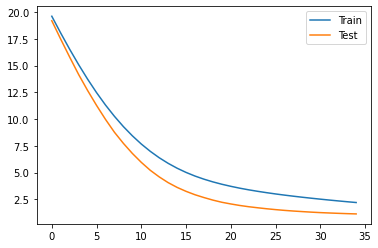

In [335]:
plt.plot(results.history['loss'], label='Train')
plt.plot(results.history['val_loss'], label='Test')
plt.legend();

In [336]:
metrics.r2_score(y_test, k_preds)

-1.4302119958510366

### 8.7 Keras on totals per month
#### Growing period July - September
This model is based on the outcome of the heath maps, datas taken during the active growing period of the plant show better correlation with the vine score.  This dataset includes both, sum and average for each month

In [337]:
# Selecting the period July- September that coincinde with the period of active growth of the plant
df_month_grow = df_month[df_month['month'].between(7, 9)]
df_month_grow.head(2)

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-07-31,13.5,923.0,584.5,753.75,443.75,338.5,1994,7,0.435484,29.774194,18.854839,4.0,24.314516,14.314516,10.919355
1994-08-31,13.5,1009.5,589.7,799.60,489.60,419.8,1994,8,0.435484,32.564516,19.022581,4.0,25.793548,15.793548,13.541935


In [338]:
# Run as regression
# X and y
X = df_month_grow.drop(columns=['score', 'dd_sum', 'month'])
y = df_month_grow['score']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [339]:
X_train.shape, 

((60, 12),)

In [340]:
ss = StandardScaler()
ss.fit(X_train, y_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [341]:
model = Sequential()
model.add(Dense(16,
activation='relu',
input_shape=(12,)))

model.add(Dense(1, activation=None))

In [342]:
# Compile the model
model.compile(loss='mse', optimizer='adam')

# Fit the model
results = model.fit(X_train_sc, y_train,
    batch_size=128, # how many samples per batch
    epochs=100,
    validation_data=(X_test_sc, y_test))

Epoch 1/100
1/1 [==============================] - 0s 193ms/step - loss: 18.5755 - val_loss: 19.0243
Epoch 2/100
1/1 [==============================] - 0s 16ms/step - loss: 18.4186 - val_loss: 18.8728
Epoch 3/100
1/1 [==============================] - 0s 19ms/step - loss: 18.2627 - val_loss: 18.7200
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 18.1077 - val_loss: 18.5678
Epoch 5/100
1/1 [==============================] - 0s 19ms/step - loss: 17.9533 - val_loss: 18.4162
Epoch 6/100
1/1 [==============================] - 0s 19ms/step - loss: 17.8006 - val_loss: 18.2658
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 17.6493 - val_loss: 18.1173
Epoch 8/100
1/1 [==============================] - 0s 20ms/step - loss: 17.4994 - val_loss: 17.9699
Epoch 9/100
1/1 [==============================] - 0s 19ms/step - loss: 17.3509 - val_loss: 17.8236
Epoch 10/100
1/1 [==============================] - 0s 20ms/step - loss: 17.2036 - val_loss: 17.678

1/1 [==============================] - 0s 17ms/step - loss: 8.9598 - val_loss: 8.7587
Epoch 83/100
1/1 [==============================] - 0s 16ms/step - loss: 8.8753 - val_loss: 8.6584
Epoch 84/100
1/1 [==============================] - 0s 17ms/step - loss: 8.7918 - val_loss: 8.5589
Epoch 85/100
1/1 [==============================] - 0s 16ms/step - loss: 8.7092 - val_loss: 8.4603
Epoch 86/100
1/1 [==============================] - 0s 15ms/step - loss: 8.6276 - val_loss: 8.3628
Epoch 87/100
1/1 [==============================] - 0s 16ms/step - loss: 8.5468 - val_loss: 8.2664
Epoch 88/100
1/1 [==============================] - 0s 15ms/step - loss: 8.4670 - val_loss: 8.1712
Epoch 89/100
1/1 [==============================] - 0s 16ms/step - loss: 8.3882 - val_loss: 8.0771
Epoch 90/100
1/1 [==============================] - 0s 16ms/step - loss: 8.3103 - val_loss: 7.9841
Epoch 91/100
1/1 [==============================] - 0s 15ms/step - loss: 8.2333 - val_loss: 7.8920
Epoch 92/100
1/1 [=====

In [343]:
# Predictions
k_preds = model.predict(X_test_sc)
#k_preds

In [344]:
metrics.r2_score(y_test, k_preds)

-12.404130866847963

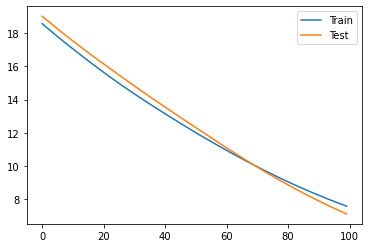

In [345]:
plt.plot(results.history['loss'], label='Train')
plt.plot(results.history['val_loss'], label='Test')
plt.legend();

### 8.8 Keras on monthly means only
This model is similar to the previous one but has limited features.  Only means for month will be featured

In [346]:
# Selecting the period July- September that coincinde with the period of active growth of the plant
df_month_grow = df_month[df_month['month'].between(7, 9)]
df_month_grow.head(2)

,prec_sum,max_sum,min_sum,t_mean_sum,dd_sum,delta_t_sum,year,month,prec_mean,max_mean,min_mean,score,t_mean_mean,dd_mean,delta_t_mean
date,,,,,,,,,,,,,,,
1994-07-31,13.5,923.0,584.5,753.75,443.75,338.5,1994,7,0.435484,29.774194,18.854839,4.0,24.314516,14.314516,10.919355
1994-08-31,13.5,1009.5,589.7,799.60,489.60,419.8,1994,8,0.435484,32.564516,19.022581,4.0,25.793548,15.793548,13.541935


In [347]:
# Run as regression
# X and y
X = df_month_grow[['max_mean', 'dd_mean', 't_mean_mean', 'min_mean', 'prec_mean']]
y = df_month_grow['score']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [348]:
X_train.shape

(60, 5)

In [349]:
ss = StandardScaler()
ss.fit(X_train, y_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [350]:
model = Sequential()
model.add(Dense(8,
activation='relu',
input_shape=(5,)))

model.add(Dense(1, activation=None))
early_stop = EarlyStopping(patience=5)

In [351]:
# Compile the model
model.compile(loss='mse', optimizer='adam')

# Fit the model
results = model.fit(X_train_sc, y_train,
    batch_size=128, # how many samples per batch
    epochs=200,
    validation_data=(X_test_sc, y_test),
    callbacks=[early_stop])
    

Epoch 1/200
1/1 [==============================] - 0s 196ms/step - loss: 22.6107 - val_loss: 23.2132
Epoch 2/200
1/1 [==============================] - 0s 16ms/step - loss: 22.4872 - val_loss: 23.0911
Epoch 3/200
1/1 [==============================] - 0s 20ms/step - loss: 22.3641 - val_loss: 22.9693
Epoch 4/200
1/1 [==============================] - 0s 17ms/step - loss: 22.2413 - val_loss: 22.8478
Epoch 5/200
1/1 [==============================] - 0s 20ms/step - loss: 22.1188 - val_loss: 22.7267
Epoch 6/200
1/1 [==============================] - 0s 19ms/step - loss: 21.9966 - val_loss: 22.6059
Epoch 7/200
1/1 [==============================] - 0s 20ms/step - loss: 21.8745 - val_loss: 22.4854
Epoch 8/200
1/1 [==============================] - 0s 22ms/step - loss: 21.7525 - val_loss: 22.3652
Epoch 9/200
1/1 [==============================] - 0s 24ms/step - loss: 21.6310 - val_loss: 22.2454
Epoch 10/200
1/1 [==============================] - 0s 19ms/step - loss: 21.5099 - val_loss: 22.126

Epoch 82/200
1/1 [==============================] - 0s 16ms/step - loss: 13.7806 - val_loss: 14.5236
Epoch 83/200
1/1 [==============================] - 0s 18ms/step - loss: 13.6882 - val_loss: 14.4331
Epoch 84/200
1/1 [==============================] - 0s 18ms/step - loss: 13.5962 - val_loss: 14.3431
Epoch 85/200
1/1 [==============================] - 0s 16ms/step - loss: 13.5047 - val_loss: 14.2535
Epoch 86/200
1/1 [==============================] - 0s 16ms/step - loss: 13.4136 - val_loss: 14.1642
Epoch 87/200
1/1 [==============================] - 0s 18ms/step - loss: 13.3230 - val_loss: 14.0749
Epoch 88/200
1/1 [==============================] - 0s 16ms/step - loss: 13.2328 - val_loss: 13.9855
Epoch 89/200
1/1 [==============================] - 0s 15ms/step - loss: 13.1431 - val_loss: 13.8966
Epoch 90/200
1/1 [==============================] - 0s 18ms/step - loss: 13.0538 - val_loss: 13.8080
Epoch 91/200
1/1 [==============================] - 0s 17ms/step - loss: 12.9649 - val_loss

1/1 [==============================] - 0s 15ms/step - loss: 7.8151 - val_loss: 8.4957
Epoch 164/200
1/1 [==============================] - 0s 15ms/step - loss: 7.7606 - val_loss: 8.4390
Epoch 165/200
1/1 [==============================] - 0s 15ms/step - loss: 7.7065 - val_loss: 8.3827
Epoch 166/200
1/1 [==============================] - 0s 21ms/step - loss: 7.6528 - val_loss: 8.3268
Epoch 167/200
1/1 [==============================] - 0s 15ms/step - loss: 7.5996 - val_loss: 8.2713
Epoch 168/200
1/1 [==============================] - 0s 15ms/step - loss: 7.5468 - val_loss: 8.2163
Epoch 169/200
1/1 [==============================] - 0s 15ms/step - loss: 7.4944 - val_loss: 8.1617
Epoch 170/200
1/1 [==============================] - 0s 16ms/step - loss: 7.4425 - val_loss: 8.1075
Epoch 171/200
1/1 [==============================] - 0s 16ms/step - loss: 7.3910 - val_loss: 8.0537
Epoch 172/200
1/1 [==============================] - 0s 16ms/step - loss: 7.3399 - val_loss: 8.0004
Epoch 173/200


In [352]:
# Predictions
k_preds = model.predict(X_test_sc)
#k_preds

In [353]:
metrics.r2_score(y_test, k_preds)

-11.585493643792539

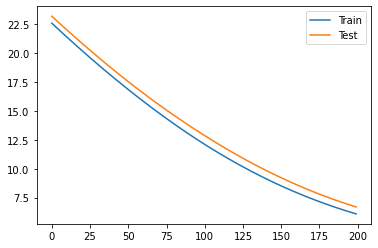

In [354]:
plt.plot(results.history['loss'], label='Train')
plt.plot(results.history['val_loss'], label='Test')
plt.legend();

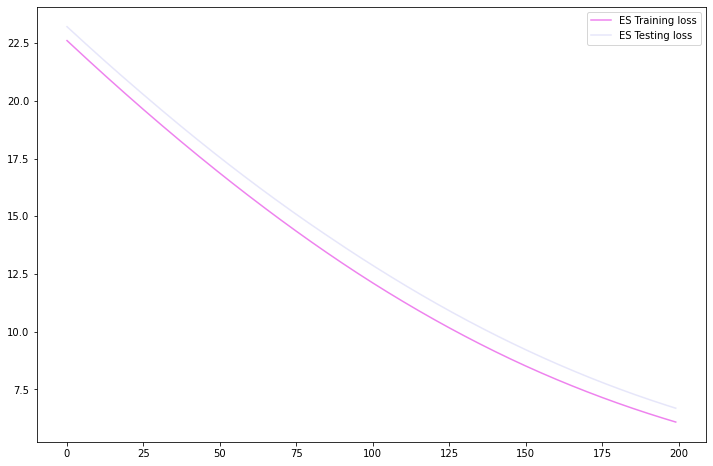

In [355]:
# To see wher it stops
train_loss_es = results.history['loss']
test_loss_es = results.history['val_loss']

plt.figure(figsize=(12, 8))
#plt.plot(train_loss, label='Training loss', color='navy')
#plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_es, label='ES Training loss', color='violet')
plt.plot(test_loss_es, label='ES Testing loss', color='lavender')
plt.legend();

# Conclusions
With the data I gathered I was unable to create a model that could successfully predict the vintage rating for the Brunello di Montalcino. <br/>
Some of the reasons that prevented achieving the goal could be:  
* Montalcino consistently produces good to excellent wines.  Too many scores are concentrated at the top, making it difficult for the model to identify any significant difference 
* Montalcino has an exceptionally unique climate, more arid than the bordering areas.  Weather data may not fully describe the unique climate and how it affects wine production.
* Temperature and precipitation data are not enough to predict the quality of this particular wine

To succeed in finding a model that can predict vintage quality the following strategies could adopted:
* Use the same approach for another wine/s from a larger area.  Other varieties in different territories may have a stronger correlation with climatic data.  This is in line with the Italian study mentioned earilier.
* Identify which period during the year is more affected by weather and add more variables. 
* Include chemical analysis
* Analyze data coming from precision agriculture, especially those that monitor the ripening process and soil properties.
* Most quality wines are produced in areas where yield is capped to a maximize quality.  This practice can mitigate the effect of climatic factors on quality.
* 